## Задача
Выполнить комплексный анализ и реализовать методы оценки и управления кредитным портфелем коммерческого банка. Рассмотреть ключевые этапы и вопросы, касающиеся подготовки данных, визуализации, анализа и применения ML и NN в кредитном скоринге.

# Импорт необходимых библиотек

In [ ]:
!pip install pyspark --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from datetime import datetime

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, when, max, min, month, year
from pyspark.sql.functions import countDistinct
from pyspark.sql import functions as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import pickle

import warnings
warnings.filterwarnings('ignore')

# Загрузка файла и подготовка имитационного кредитного портфеля

In [ ]:
# загрузка файла csv
loans = pd.read_csv('credit_risk_dataset.csv')
loans

person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0             PERSONAL          D      35000          16.02            1   
1            EDUCATION          B       1000          11.14            0   
2              MEDICAL          C       5500          12.87            1   
3              MEDICAL          C      35000          15.23            1   
4              MEDICAL          C      35000          14.27            1   
...                ...        ...        ...            ...          ...   
32576         PERSONAL          C       5800          13.16            0   
32577         PERSONAL          A      17625           7.49            0   
32578  HOMEIMPROVEMENT          B      35000          10.99            1   
32579         PERSONAL          B      15000          11.48            0   
32580          MEDICAL          B       6475           9.99            0   

       loan_percent_income cb_person_default_on_file  \
0                     0.59                         Y   
1                     0.10                         N   
2                     0.57                         N   
3                     0.53                         N   
4                     0.55                         Y   
...                    ...                       ...   
32576                 0.11                         N   
32577                 0.15                         N   
32578                 0.46                         N   
32579                 0.10                         N   
32580                 0.15                         N   

       cb_person_cred_hist_length  
0                               3  
1                               2  
2                               3  
3                               2  
4                               4  
...                           ...  
32576                          30  
32577                          19  
32578                          28  
32579                          26  
32580                          30  

[32581 rows x 12 columns]

Подготовка списка субъектов РФ на английском языке

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Russia'
df = pd.read_html(url)[0]
spisok = df['Federal subject'].unique()
spisok.tolist()

['Republic of Khakassia',
 'Orenburg Oblast',
 'Krasnodar Krai',
 'Krasnoyarsk Krai',
 'Republic of Adygea',
 'Republic of Bashkortostan',
 'Republic of Tatarstan',
 'Tuva Republic',
 'Astrakhan Oblast',
 'Rostov Oblast',
 'Republic of North Ossetia–Alania',
 'Sverdlovsk Oblast',
 'Chuvash Republic',
 'Sakha Republic',
 'Tula Oblast',
 'Vladimir Oblast',
 'Perm Krai',
 'Sakhalin Oblast',
 'Belgorod Oblast',
 'Altai Krai',
 'Republic of Crimea',
 'Irkutsk Oblast',
 'Khabarovsk Krai',
 'Chukotka Autonomous Okrug',
 'Tver Oblast',
 'Kemerovo Oblast',
 'Murmansk Oblast',
 'Moscow Oblast',
 'Republic of Mordovia',
 'Chechen Republic',
 'Saratov Oblast',
 'Arkhangelsk Oblast',
 'Primorsky Krai',
 'Republic of Tatarstan[1]',
 'Nizhny Novgorod Oblast',
 'Chelyabinsk Oblast',
 'Tomsk Oblast',
 'Vologda Oblast',
 'Republic of Buryatia',
 'Kaliningrad Oblast',
 'Kabardino-Balkar Republic',
 'Kaluga Oblast',
 'Zabaykalsky Krai',
 'Novosibirsk Oblast',
 'Ulyanovsk Oblast',
 'Kirov Oblast',
 'Penza 

In [ ]:
www = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # веса для случайного выбора

Формирование признака "локации филиалов" - "location"

In [ ]:
# формирование признака "локации филиалов"
random.seed(1)
weights_location = random.choices(www, k=len(spisok)) # веса для случайного выбора локаций
loans['location'] = random.choices(spisok, weights=weights_location, k=len(loans))

Формирование признака "дата выдачи кредита"

In [ ]:
# формирование признака "дата выдачи кредита"
n_samples = loans.shape[0]
dt_from = pd.to_datetime("2024-01-15")
dt_to = pd.to_datetime("2024-12-15")

random.seed(1)
days = pd.date_range(dt_from, dt_to, periods=n_samples)
weights_dates = random.choices(www, k=len(days)) # веса для случайного выбора дат

loans['dates'] = random.choices(days, weights=weights_dates, k=len(loans))

loans['date'] = pd.to_datetime(loans['dates']).dt.date
loans = loans.drop(columns=['dates'])

loans['date'] = pd.to_datetime(loans['date'], format='%Y-%m-%d')

In [ ]:
loans.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.59                         Y                           3   
1                 0.10                         N                           2   
2                 0.57                         N                           3   
3                 0.53                         N                           2   
4                 0.55                         Y                           4   

                   location       date  
0            Magadan Oblast 2024-02-25  
1  Jewish Autonomous Oblast 2024-02-07  
2          Zabaykalsky Krai 2024-10-10  
3           Khabarovsk Krai 2024-06-12  
4                   Karelia 2024-09-04

In [ ]:
print("Размер датасета:", loans.shape)
print("Количество дубликатов:", loans.duplicated().sum())
print("Содержит NaN:", loans.isnull().any().any())
print("Пропущенные значения:")
print(loans.isnull().sum())

Размер датасета: (32581, 14)
Количество дубликатов: 0
Содержит NaN: True
Пропущенные значения:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
location                         0
date                             0
dtype: int64


Обработка пропущенных значений - заполнение медианным значением

In [ ]:
loans['person_emp_length'].fillna((loans['person_emp_length'].median()), inplace=True)
loans['loan_int_rate'].fillna((loans['loan_int_rate'].median()), inplace = True)

In [ ]:
loans.describe().T

count                           mean  \
person_age                  32581.0                        27.7346   
person_income               32581.0                    66074.84847   
person_emp_length           32581.0                       4.767994   
loan_amnt                   32581.0                    9589.371106   
loan_int_rate               32581.0                       11.00962   
loan_status                 32581.0                       0.218164   
loan_percent_income         32581.0                       0.170203   
cb_person_cred_hist_length  32581.0                       5.804211   
date                          32581  2024-06-30 17:12:08.706914816   

                                            min                  25%  \
person_age                                 20.0                 23.0   
person_income                            4000.0              38500.0   
person_emp_length                           0.0                  2.0   
loan_amnt                                 500.0               5000.0   
loan_int_rate                              5.42                 8.49   
loan_status                                 0.0                  0.0   
loan_percent_income                         0.0                 0.09   
cb_person_cred_hist_length                  2.0                  3.0   
date                        2024-01-15 00:00:00  2024-04-07 00:00:00   

                                            50%                  75%  \
person_age                                 26.0                 30.0   
person_income                           55000.0              79200.0   
person_emp_length                           4.0                  7.0   
loan_amnt                                8000.0              12200.0   
loan_int_rate                             10.99                13.11   
loan_status                                 0.0                  0.0   
loan_percent_income                        0.15                 0.23   
cb_person_cred_hist_length                  4.0                  8.0   
date                        2024-07-01 00:00:00  2024-09-23 00:00:00   

                                            max           std  
person_age                                144.0      6.348078  
person_income                         6000000.0  61983.119168  
person_emp_length                         123.0      4.087372  
loan_amnt                               35000.0   6322.086646  
loan_int_rate                             23.22      3.081611  
loan_status                                 1.0      0.413006  
loan_percent_income                        0.83      0.106782  
cb_person_cred_hist_length                 30.0      4.055001  
date                        2024-12-14 00:00:00           NaN

Удаление дубликатов

In [ ]:
loans.drop_duplicates(inplace=True)

In [ ]:
loans.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.59                         Y                           3   
1                 0.10                         N                           2   
2                 0.57                         N                           3   
3                 0.53                         N                           2   
4                 0.55                         Y                           4   

                   location       date  
0            Magadan Oblast 2024-02-25  
1  Jewish Autonomous Oblast 2024-02-07  
2          Zabaykalsky Krai 2024-10-10  
3           Khabarovsk Krai 2024-06-12  
4                   Karelia 2024-09-04

Обработка выбросов, присутствующих в признаках "возраст" и "трудовой стаж"

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [ ]:
loans = remove_outlier(loans, 'person_age')

In [ ]:
loans = remove_outlier(loans, 'person_emp_length')

In [ ]:
loans.describe().T

count                           mean  \
person_age                  30392.0                      26.647111   
person_income               30392.0                   64559.079363   
person_emp_length           30392.0                       4.417643   
loan_amnt                   30392.0                    9534.317419   
loan_int_rate               30392.0                      11.017091   
loan_status                 30392.0                       0.219564   
loan_percent_income         30392.0                       0.170933   
cb_person_cred_hist_length  30392.0                       5.229534   
date                          30392  2024-06-30 22:44:56.920241920   

                                            min                  25%  \
person_age                                 20.0                 23.0   
person_income                            4080.0              38238.0   
person_emp_length                           0.0                  2.0   
loan_amnt                                 500.0               5000.0   
loan_int_rate                              5.42                 8.49   
loan_status                                 0.0                  0.0   
loan_percent_income                         0.0                 0.09   
cb_person_cred_hist_length                  2.0                  3.0   
date                        2024-01-15 00:00:00  2024-04-08 00:00:00   

                                            50%                  75%  \
person_age                                 25.0                 29.0   
person_income                           55000.0              78000.0   
person_emp_length                           4.0                  7.0   
loan_amnt                                8000.0              12000.0   
loan_int_rate                             10.99                13.11   
loan_status                                 0.0                  0.0   
loan_percent_income                        0.15                 0.23   
cb_person_cred_hist_length                  4.0                  7.0   
date                        2024-07-01 00:00:00  2024-09-23 00:00:00   

                                            max           std  
person_age                                 40.0      4.425236  
person_income                         1200000.0  45091.158735  
person_emp_length                          14.0      3.380452  
loan_amnt                               35000.0   6279.474453  
loan_int_rate                             23.22       3.07719  
loan_status                                 1.0      0.413958  
loan_percent_income                        0.83      0.106805  
cb_person_cred_hist_length                 17.0      3.282588  
date                        2024-12-14 00:00:00           NaN

In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30392 entries, 1 to 32296
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   person_age                  30392 non-null  int64         
 1   person_income               30392 non-null  int64         
 2   person_home_ownership       30392 non-null  object        
 3   person_emp_length           30392 non-null  float64       
 4   loan_intent                 30392 non-null  object        
 5   loan_grade                  30392 non-null  object        
 6   loan_amnt                   30392 non-null  int64         
 7   loan_int_rate               30392 non-null  float64       
 8   loan_status                 30392 non-null  int64         
 9   loan_percent_income         30392 non-null  float64       
 10  cb_person_default_on_file   30392 non-null  object        
 11  cb_person_cred_hist_length  30392 non-null  int64         


In [ ]:
print("Размер датасета:", loans.shape)
print("Количество дубликатов:", loans.duplicated().sum())
print("Содержит NaN:", loans.isnull().any().any())
print("Пропущенные значения:")
print(loans.isnull().sum())

Размер датасета: (30392, 14)
Количество дубликатов: 0
Содержит NaN: False
Пропущенные значения:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
location                      0
date                          0
dtype: int64


Имитационный датасет готов, пропусков и дубликатов нет.Сохранение в csv для дальнейшей аналитики с применением инструментов Power BI.

In [ ]:
loans.to_csv('loans_clear.csv')

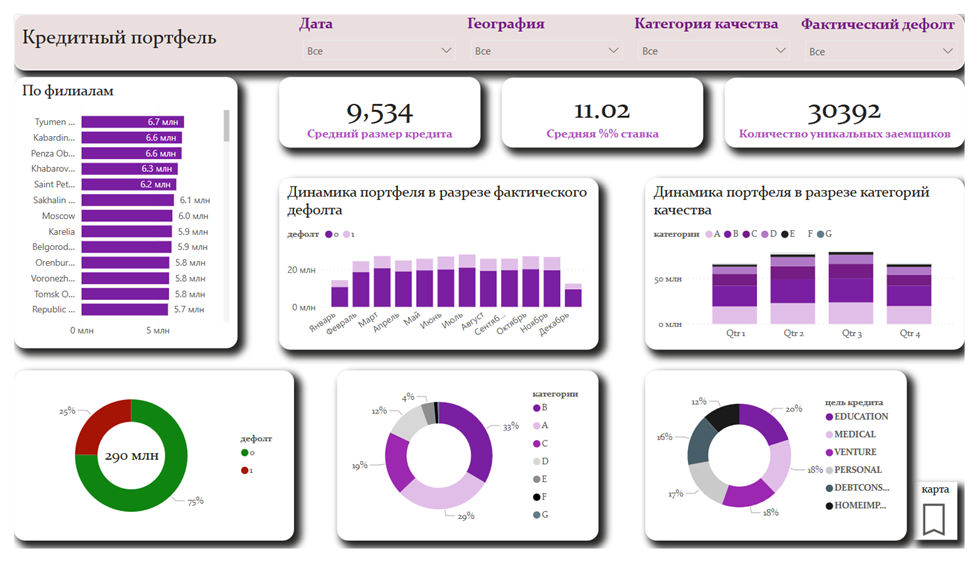

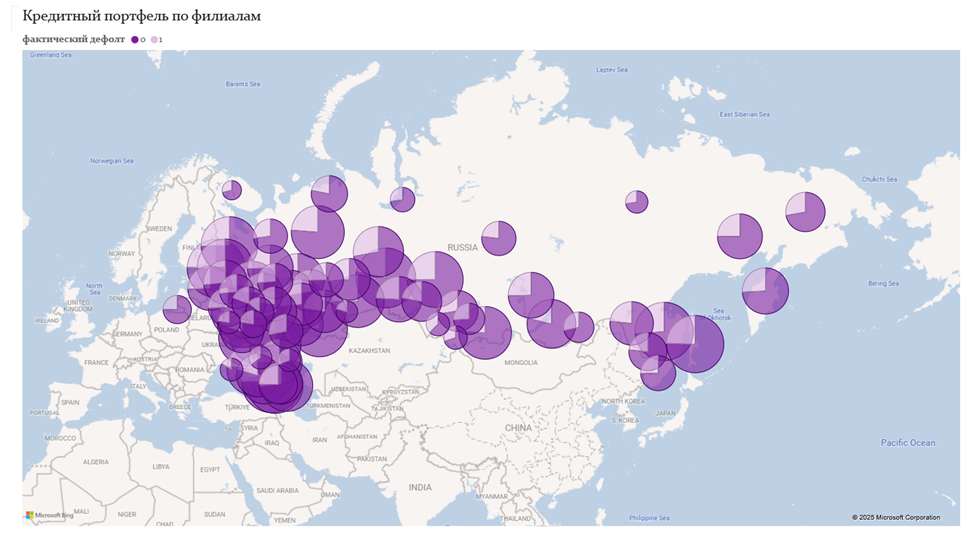

# Анализ кредитного портфеля

## Анализ кредитного портфеля с применением инструментов Pandas

In [ ]:
loans_analysis = loans
loans_analysis

person_age  person_income person_home_ownership  person_emp_length  \
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
5              21           9900                   OWN                2.0   
...           ...            ...                   ...                ...   
32289          40          33000              MORTGAGE                2.0   
32290          37          90000              MORTGAGE               11.0   
32292          38         200000              MORTGAGE                0.0   
32293          38         110000              MORTGAGE                5.0   
32296          40          52000                  RENT                2.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1              EDUCATION          B       1000          11.14            0   
2                MEDICAL          C       5500          12.87            1   
3                MEDICAL          C      35000          15.23            1   
4                MEDICAL          C      35000          14.27            1   
5                VENTURE          A       2500           7.14            1   
...                  ...        ...        ...            ...          ...   
32289    HOMEIMPROVEMENT          B       1000          10.99            0   
32290  DEBTCONSOLIDATION          A       4000           6.62            0   
32292  DEBTCONSOLIDATION          A       3000           7.68            0   
32293            MEDICAL          B      16000          11.99            0   
32296          EDUCATION          F      15000          18.62            1   

       loan_percent_income cb_person_default_on_file  \
1                     0.10                         N   
2                     0.57                         N   
3                     0.53                         N   
4                     0.55                         Y   
5                     0.25                         N   
...                    ...                       ...   
32289                 0.03                         N   
32290                 0.04                         N   
32292                 0.01                         N   
32293                 0.15                         N   
32296                 0.29                         Y   

       cb_person_cred_hist_length                  location       date  
1                               2  Jewish Autonomous Oblast 2024-02-07  
2                               3          Zabaykalsky Krai 2024-10-10  
3                               2           Khabarovsk Krai 2024-06-12  
4                               4                   Karelia 2024-09-04  
5                               2            Magadan Oblast 2024-09-23  
...                           ...                       ...        ...  
32289                          15          Saint Petersburg 2024-01-18  
32290                          15             Tuva Republic 2024-09-19  
32292                          12          Yaroslavl Oblast 2024-04-24  
32293                          13             Tambov Oblast 2024-07-05  
32296                          16             Moscow Oblast 2024-01-17  

[30392 rows x 14 columns]

In [ ]:
print("Размер датасета:", loans_analysis.shape)
print("Количество дубликатов:", loans_analysis.duplicated().sum())
print("Содержит NaN:", loans_analysis.isnull().any().any())
print("Пропущенные значения:")
print(loans_analysis.isnull().sum())

Размер датасета: (30392, 14)
Количество дубликатов: 0
Содержит NaN: False
Пропущенные значения:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
location                      0
date                          0
dtype: int64


In [ ]:
loans_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30392 entries, 1 to 32296
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   person_age                  30392 non-null  int64         
 1   person_income               30392 non-null  int64         
 2   person_home_ownership       30392 non-null  object        
 3   person_emp_length           30392 non-null  float64       
 4   loan_intent                 30392 non-null  object        
 5   loan_grade                  30392 non-null  object        
 6   loan_amnt                   30392 non-null  int64         
 7   loan_int_rate               30392 non-null  float64       
 8   loan_status                 30392 non-null  int64         
 9   loan_percent_income         30392 non-null  float64       
 10  cb_person_default_on_file   30392 non-null  object        
 11  cb_person_cred_hist_length  30392 non-null  int64         


In [ ]:
loans_analysis.head()

person_age  person_income person_home_ownership  person_emp_length  \
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   
5     VENTURE          A       2500           7.14            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
1                 0.10                         N                           2   
2                 0.57                         N                           3   
3                 0.53                         N                           2   
4                 0.55                         Y                           4   
5                 0.25                         N                           2   

                   location       date  
1  Jewish Autonomous Oblast 2024-02-07  
2          Zabaykalsky Krai 2024-10-10  
3           Khabarovsk Krai 2024-06-12  
4                   Karelia 2024-09-04  
5            Magadan Oblast 2024-09-23

In [ ]:
loans_analysis.describe().T

count                           mean  \
person_age                  30392.0                      26.647111   
person_income               30392.0                   64559.079363   
person_emp_length           30392.0                       4.417643   
loan_amnt                   30392.0                    9534.317419   
loan_int_rate               30392.0                      11.017091   
loan_status                 30392.0                       0.219564   
loan_percent_income         30392.0                       0.170933   
cb_person_cred_hist_length  30392.0                       5.229534   
date                          30392  2024-06-30 22:44:56.920241920   

                                            min                  25%  \
person_age                                 20.0                 23.0   
person_income                            4080.0              38238.0   
person_emp_length                           0.0                  2.0   
loan_amnt                                 500.0               5000.0   
loan_int_rate                              5.42                 8.49   
loan_status                                 0.0                  0.0   
loan_percent_income                         0.0                 0.09   
cb_person_cred_hist_length                  2.0                  3.0   
date                        2024-01-15 00:00:00  2024-04-08 00:00:00   

                                            50%                  75%  \
person_age                                 25.0                 29.0   
person_income                           55000.0              78000.0   
person_emp_length                           4.0                  7.0   
loan_amnt                                8000.0              12000.0   
loan_int_rate                             10.99                13.11   
loan_status                                 0.0                  0.0   
loan_percent_income                        0.15                 0.23   
cb_person_cred_hist_length                  4.0                  7.0   
date                        2024-07-01 00:00:00  2024-09-23 00:00:00   

                                            max           std  
person_age                                 40.0      4.425236  
person_income                         1200000.0  45091.158735  
person_emp_length                          14.0      3.380452  
loan_amnt                               35000.0   6279.474453  
loan_int_rate                             23.22       3.07719  
loan_status                                 1.0      0.413958  
loan_percent_income                        0.83      0.106805  
cb_person_cred_hist_length                 17.0      3.282588  
date                        2024-12-14 00:00:00           NaN

Кредитный портфель содержит данные о 30392 заемщиках

Признаки:

person_age Возраст заемщика

person_income Персональный годовой доход

person_home_ownership Тип владения недвижимостью

person_emp_length Трудовой стаж в годах

loan_intent Цель кредитования

loan_grade Категория качества заемщика

loan_amnt Размер кредита

loan_int_rate Процентная ставка

loan_percent_income Процентное соотношение кредита к годовому доходу

cb_person_default_on_file Допускался ли дефолт ранее

cb_preson_cred_hist_length Кредитная история в месяцах

location Филиал

date Дата выдачи кредита

loan_status Фактический дефолт - целевая переменная

0: Нет дефолта — заемщик успешно погасил кредит в соответствии с договоренностью, и дефолта не было.

1: Дефолт — заемщик не погасил кредит в соответствии с договоренными условиями и допустил дефолт по кредиту.

При формировании имитационного датасета уже была проведена работа по удалению дубликатов, заполнению пропущенных значений и корректировке выбросов. Поэтому первичный анализ показывает, что:

минимальный размер кредита - 500

максимальный размер кредита - 35000

минимальная %% ставка - 5,42

максимальная %% ставка - 23,22

Создание дополнительного признака 'loan_month' - месяц выдачи кредита

In [ ]:
# создание дополнительного признака 'loan_month' - месяц выдачи кредита
loans_analysis['loan_month'] = loans_analysis['date'].dt.month

### Распределение кредитного портфеля по месяцам (общая сумма, среднее, минимальное и максимальное значение)

In [ ]:
result = loans_analysis.groupby(["loan_month"]).agg({'loan_amnt':['sum','mean','min','max']})
result.sort_values(('loan_amnt', 'sum'), ascending=False)

loan_amnt                          
                 sum         mean   min    max
loan_month                                    
7           28073550  9607.648871  1000  35000
3           27256275  9496.959930  1000  35000
10          27147000  9712.701252   500  35000
6           26969650  9590.913940   750  35000
11          26752025  9489.898900   500  35000
9           25867625  9569.968553  1000  35000
8           25809950  9566.326909  1000  35000
5           25793175  9331.828871   800  35000
4           24849450  9513.571975   500  35000
2           24469325  9614.666012   725  35000
1           14318000  9364.290386   500  35000
12          12460950  9418.707483  1000  35000

Вывод: больше всего кредитов выдавалось в июле, меньше всего - в декабре

### Группировка кредитов по целевому признаку

In [ ]:
loans_analysis.groupby(["loan_intent"]).agg({'loan_amnt':'sum'}).sort_values('loan_amnt', ascending=False)

loan_amnt
loan_intent                 
EDUCATION           58136125
MEDICAL             51623600
VENTURE             50904625
PERSONAL            48300900
DEBTCONSOLIDATION   46667600
HOMEIMPROVEMENT     34134125

Вывод: Основными целями получения кредитов являются образование и лечение

### TOP 3 регионов с самой большой суммой выданных кредитов

In [ ]:
loans_analysis.groupby(["location"]).agg({'loan_amnt':'sum'}).sort_values('loan_amnt', ascending=False).head(3)

loan_amnt
location                            
Tyumen Oblast                6744200
Kabardino-Balkar Republic    6608075
Penza Oblast                 6584400

### Кредитный портфель в разбивке по регионам с указанием среднего размера кредита

In [ ]:
loans_analysis.groupby(["location"]).agg({'loan_amnt':['sum','mean']}).sort_values(('loan_amnt', 'sum'), ascending=False)

loan_amnt             
                                sum         mean
location                                        
Tyumen Oblast               6744200  9634.571429
Kabardino-Balkar Republic   6608075  9426.640514
Penza Oblast                6584400  9976.363636
Khabarovsk Krai             6332775  9522.969925
Saint Petersburg            6237350  9351.349325
...                             ...          ...
Astrakhan Oblast             635475  9484.701493
Sakha Republic               620675  8620.486111
Bryansk Oblast               614825  9315.530303
Chelyabinsk Oblast           560750  9044.354839
Murmansk Oblast              407375  8667.553191

[85 rows x 2 columns]

Вывод: Филиал банка в Тюменской области имеет самый большой кредитный портфель

### Кредитный портфель по регионам с разбивкой по категориям качества кредита

In [ ]:
loans_analysis.pivot_table(index='location', columns='loan_grade', values='loan_amnt', aggfunc='mean') \
              .sort_values('A', ascending=False).head(7)

loan_grade                   A             B            C             D  \
location                                                                  
Kostroma Oblast   10390.983607   9078.358209  8438.095238  11957.407407   
Perm Krai         10028.000000   9969.672131  8605.434783  11545.192308   
Tula Oblast        9880.045872  10336.458333  9898.170732  11313.207547   
Zabaykalsky Krai   9845.930233   9437.755102  9933.333333   7879.545455   
Rostov Oblast      9709.782609  10297.222222  6280.000000  11200.000000   
Altai Krai         9470.000000   8959.210526  8779.166667  11480.555556   
Primorsky Krai     9443.750000  11013.983051  8867.424242  11167.391304   

loan_grade                   E        F   G  
location                                     
Kostroma Oblast   14800.000000      NaN NaN  
Perm Krai          9733.333333  13600.0 NaN  
Tula Oblast        9223.076923  11875.0 NaN  
Zabaykalsky Krai  18333.333333  25000.0 NaN  
Rostov Oblast     10025.000000  17500.0 NaN  
Altai Krai        13050.000000  25000.0 NaN  
Primorsky Krai    10571.428571      NaN NaN

Вывод: кредиты с высокими категориями качества (А и В) выдают филиалы в Костромской области, Приморском и Пермском крае

## Анализ кредитного портфеля с применением инструментов Apache Spark

In [ ]:
#Создаем SparkSession
spark=SparkSession.builder.appName('Analysis').getOrCreate()

In [ ]:
#Загружаем датасет
loans_pyspark = spark.read.load('loans_clear.csv', format="csv", sep=",", header="true", Infer_schema=True)

Создание дополнительного признака 'loan_month' - месяц выдачи кредита

In [ ]:
#добавление колонки со значением месяца
loans_pyspark = loans_pyspark.withColumn("loan_month", month(loans_pyspark["date"]))

In [ ]:
loans_pyspark.show()

+---+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+--------------------+----------+----------+
|_c0|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|            location|      date|loan_month|
+---+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+--------------------+----------+----------+
|  1|        21|         9600|                  OWN|              5.0|        EDUCATION|         B|     1000|        11.14|          0|                0.1|                        N|                         2|Jewish Autonomous...|2024-02-07|    

In [ ]:
#необходимые преобразования
loans_pyspark = loans_pyspark.withColumn("date", loans_pyspark["date"].cast('date'))
loans_pyspark = loans_pyspark.withColumn("loan_amnt", loans_pyspark["loan_amnt"].cast('int'))

### Распределение кредитного портфеля по месяцам (общая сумма, среднее, минимальное и максимальное значение)

In [ ]:
#нахождение нужных значений
loans_analys = loans_pyspark.groupBy("loan_month").agg(
                            sum("loan_amnt").alias("total_loans"),
                            avg("loan_amnt").alias("average_loans"),
                            max("loan_amnt").alias("max_loans"),
                            min("loan_amnt").alias("min_loans"))

#вывод результата с сортировкой
loans_analys.orderBy('total_loans', ascending=False).show()

+----------+-----------+-----------------+---------+---------+
|loan_month|total_loans|    average_loans|max_loans|min_loans|
+----------+-----------+-----------------+---------+---------+
|         7|   28073550| 9607.64887063655|    35000|     1000|
|         3|   27256275| 9496.95993031359|    35000|     1000|
|        10|   27147000|9712.701252236136|    35000|      500|
|         6|   26969650|9590.913940256045|    35000|      750|
|        11|   26752025|9489.898900319262|    35000|      500|
|         9|   25867625|9569.968553459119|    35000|     1000|
|         8|   25809950| 9566.32690882135|    35000|     1000|
|         5|   25793175|9331.828871201158|    35000|      800|
|         4|   24849450|9513.571975497704|    35000|      500|
|         2|   24469325| 9614.66601178782|    35000|      725|
|         1|   14318000|9364.290385873119|    35000|      500|
|        12|   12460950|9418.707482993197|    35000|     1000|
+----------+-----------+-----------------+---------+---

Вывод: больше всего кредитов выдавалось в июле, меньше всего - в декабре

###Группировка кредитов по целевому признаку

In [ ]:
#нахождение нужных значений
intent_analys = loans_pyspark.groupBy("loan_intent").agg(sum("loan_amnt").alias("loan_intent"))

#вывод результата
intent_analys.orderBy('loan_intent').show()

+-----------------+-----------+
|      loan_intent|loan_intent|
+-----------------+-----------+
|DEBTCONSOLIDATION|   46667600|
|        EDUCATION|   58136125|
|  HOMEIMPROVEMENT|   34134125|
|          MEDICAL|   51623600|
|         PERSONAL|   48300900|
|          VENTURE|   50904625|
+-----------------+-----------+



Вывод: Основными целями получения кредитов являются образование и лечение


### TOP 3 регионов с самой большой суммой выданных кредитов

In [ ]:
#нахождение нужных значениях
region_analys = loans_pyspark.groupBy("location") \
  .agg(sum("loan_amnt").alias("total_loan_per_region"))

total_loan_per_region = region_analys.select("location", "total_loan_per_region") \
  .orderBy(region_analys.total_loan_per_region.desc()).take(3)

#вывод результата
for row in total_loan_per_region:
    print(row['location'], row['total_loan_per_region'])

Tyumen Oblast 6744200
Kabardino-Balkar Republic 6608075
Penza Oblast 6584400


### Кредитный портфель в разбивке по регионам с указанием среднего размера кредита

In [ ]:
#нахождение нужных значениях
loans_analys = loans_pyspark.groupBy("location").agg(
    sum("loan_amnt").alias("total_loans_per_region"),
    avg("loan_amnt").alias("avg_loan_per_region")
)
#вывод результата
loans_analys.orderBy('total_loans_per_region',ascending=False).show()

+--------------------+----------------------+-------------------+
|            location|total_loans_per_region|avg_loan_per_region|
+--------------------+----------------------+-------------------+
|       Tyumen Oblast|               6744200|   9634.57142857143|
|Kabardino-Balkar ...|               6608075|  9426.640513552069|
|        Penza Oblast|               6584400|  9976.363636363636|
|     Khabarovsk Krai|               6332775|   9522.96992481203|
|    Saint Petersburg|               6237350|   9351.34932533733|
|     Sakhalin Oblast|               6078450|  9280.076335877862|
|              Moscow|               5977875|  9704.342532467532|
|             Karelia|               5949350|   9354.32389937107|
|     Belgorod Oblast|               5920975|       9251.5234375|
|     Orenburg Oblast|               5774225|   9607.69550748752|
|     Voronezh Oblast|               5763650|  9495.304777594729|
|        Tomsk Oblast|               5755400|  9238.202247191011|
|Republic 

Вывод: Филиал банка в Тюменской области имеет самый большой кредитный портфель

### Кредитный портфель по регионам с разбивкой по категориям качества кредита

In [ ]:
# Применение функции pivot
pivot_loans = loans_pyspark.groupBy("location").pivot("loan_grade").agg(F.avg("loan_amnt"))

# Вывод средних размеров кредита по категориям качества
pivot_loans.orderBy('A', ascending=False).show()

+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------+
|            location|                 A|                 B|                C|                 D|                 E|                 F|      G|
+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------+
|     Kostroma Oblast|10390.983606557376| 9078.358208955224|8438.095238095239|11957.407407407407|           14800.0|              NULL|   NULL|
|           Perm Krai|           10028.0| 9969.672131147541|8605.434782608696|11545.192307692309| 9733.333333333334|           13600.0|   NULL|
|         Tula Oblast| 9880.045871559632|10336.458333333334|9898.170731707318|11313.207547169812| 9223.076923076924|           11875.0|   NULL|
|    Zabaykalsky Krai|  9845.93023255814| 9437.755102040815|9933.333333333334| 7879.545454545455|18333.333333333332|           25000.0| 

Вывод: кредиты с высокими категориями качества (А и В) выдают филиалы в Костромской области, Приморском и Пермском крае

In [ ]:
spark.stop()

### Вывод

Полученные данные в результате анализа Spark полностью совпадают с выводами, полученными с применением стандартных библиотек Python

## Визуализации

### Взаимосвязь между доходом заемщика и размером выданного кредита

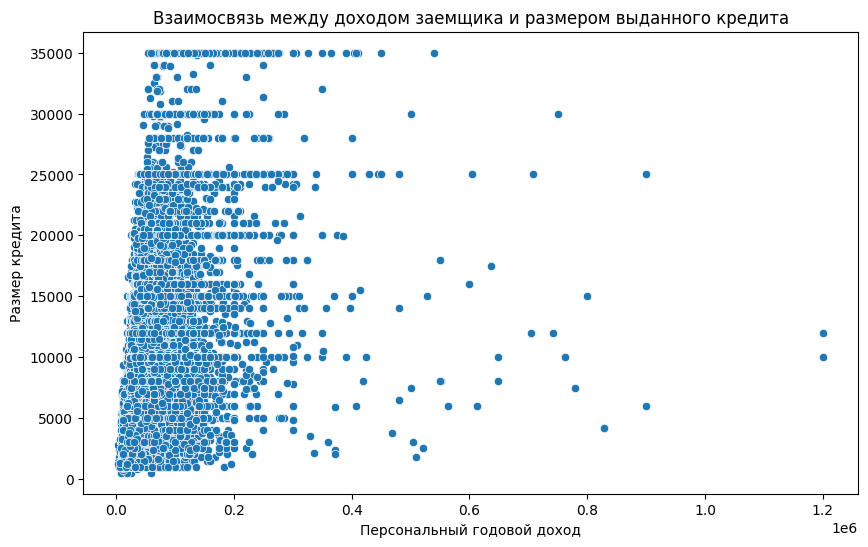

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="person_income", y="loan_amnt", data=loans_analysis)
plt.title('Взаимосвязь между доходом заемщика и размером выданного кредита')
plt.xlabel('Персональный годовой доход')
plt.ylabel('Размер кредита')
plt.show()

Вывод: прямой зависимости не прослеживается, по всей видимости, максимальный размер кредита ограничен нормативами кредитной политики банка

### Распределение количества выданных кредитов, сгруппированное по возрастам заемщиков

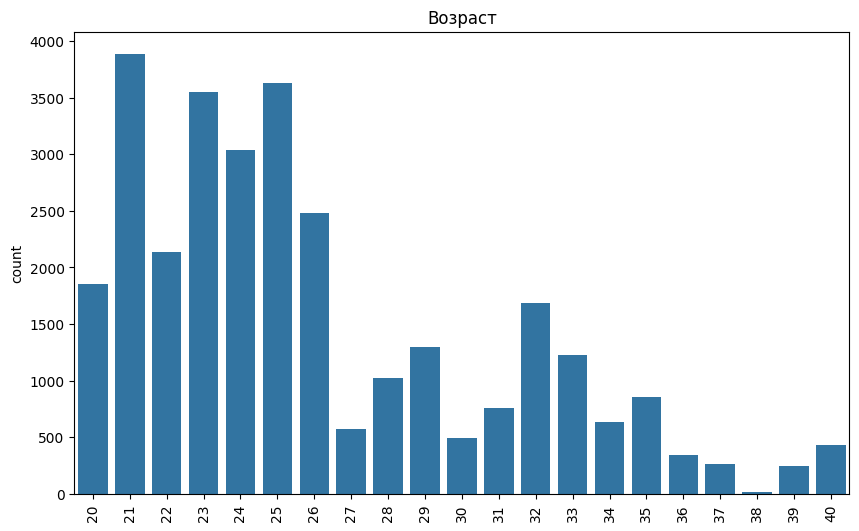

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=loans_analysis['person_age'].unique(), y=loans_analysis['person_age'].value_counts())
plt.xticks(rotation=90)
plt.title('Возраст')
plt.show()

Вывод: больше всего кредитов получают молодые люди в возрасте до 27 лет- этот вывод коррелирует с наиболее частым целевым назначением кредита "образование"

### Распределение количества кредитов, сгруппированное по категориям качества

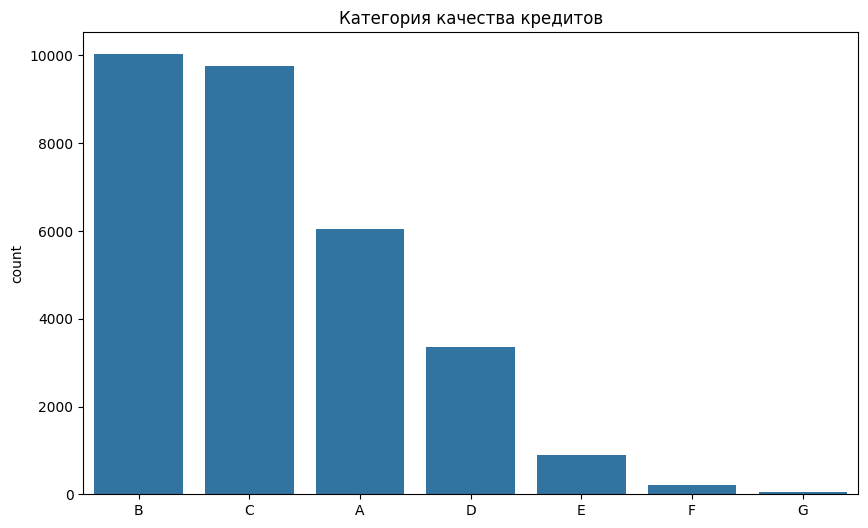

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=loans_analysis['loan_grade'].unique(), y=loans_analysis['loan_grade'].value_counts())
plt.title('Категория качества кредитов')
plt.show()

Вывод: В кредитном портфеле преобладают кредиты средней категории качества ("В" и "С"), кредиты категории "А" не превалируют, что является не вполне тревожным признаком, но моментом, на который необходимо обратить внимание

### Взаимосвязь между целью кредитования и персональным доходом

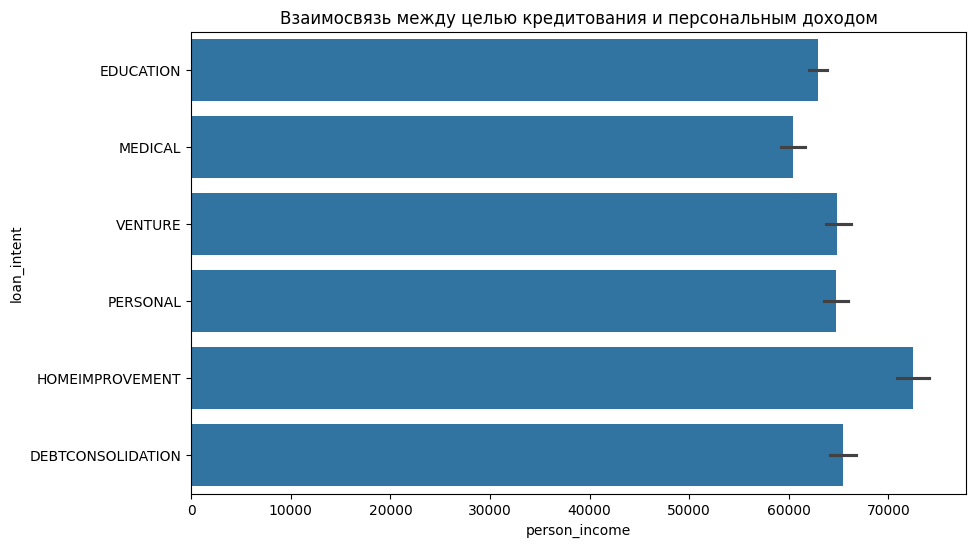

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=loans_analysis["person_income"],y=loans_analysis["loan_intent"])
plt.title("Взаимосвязь между целью кредитования и персональным доходом")
plt.show()

Вывод: Распределение в данном кредитном портфеле примерно равномерное

### Распределение фактического дефолта по категориям качества

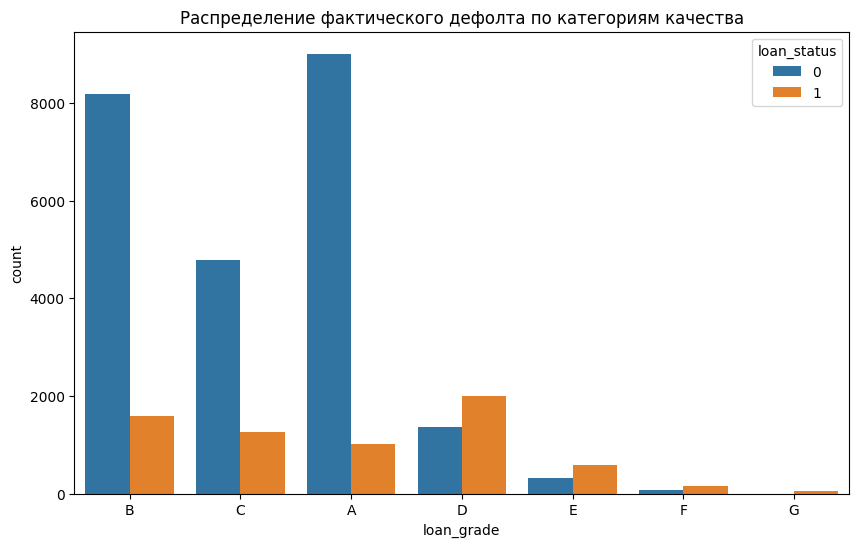

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data = loans_analysis, x = 'loan_grade', hue = 'loan_status')
plt.title("Распределение фактического дефолта по категориям качества")
plt.show()

Вывод: к сожалению, необходимо отметить факт того, что среди наиболее высоких категорий качества ("А", "В", "С") фактический дефолт присутствует в некотором соотношении. Большое оно или маленькое - необходимо экспертное мнение кредитного аналитика.

### Распределение кредитного портфеля по фактическому дефолту

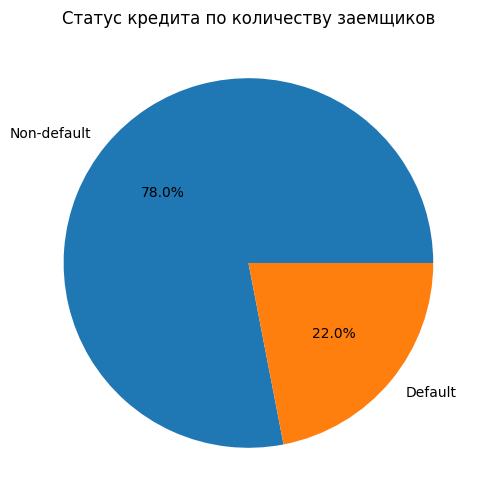

In [ ]:
plt.figure(figsize=(10,6))
plt.pie(loans_analysis['loan_status'].value_counts(), labels=['Non-default', 'Default'], autopct='%1.1f%%')
plt.title("Статус кредита по количеству заемщиков")
plt.show()

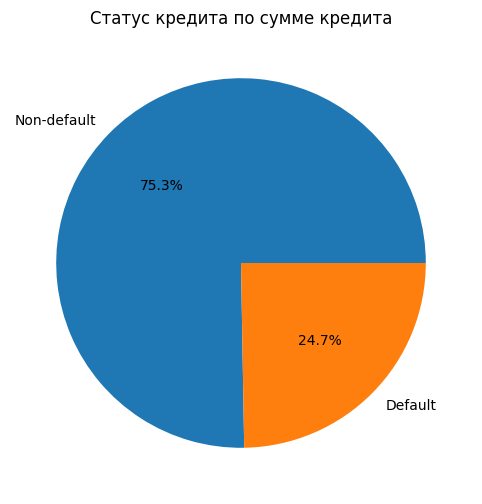

In [ ]:
loan_sum_by_status = loans_analysis.groupby('loan_status')['loan_amnt'].sum()
labels = ['Non-default', 'Default']

plt.figure(figsize=(10,6))
plt.pie(loan_sum_by_status, labels=labels, autopct='%1.1f%%')
plt.title("Статус кредита по сумме кредита")
plt.show()

### Вывод

Процент проблемных кредитов в размере 22% (а в денежном выражении 25%) от всего объема кредитного портфеля банка является очень большим. На мой взгляд, значение, превышающее 7-10% является критическим. В банке необходимо в достаточно срочном порядке корректировать подходы к кредитованию физических лиц, более консервативно подходя к регламенту выдачи потребительских ссуд.

# Применение машинного обучения (ML) и нейронных сетей (NN) для прогнозирования вероятности выдачи кредита

## Препроцессинг

### Загрузка данных

In [ ]:
loans_ml = loans
loans_ml = loans_ml.reset_index(drop=True)
loans_ml

person_age  person_income person_home_ownership  person_emp_length  \
0              21           9600                   OWN                5.0   
1              25           9600              MORTGAGE                1.0   
2              23          65500                  RENT                4.0   
3              24          54400                  RENT                8.0   
4              21           9900                   OWN                2.0   
...           ...            ...                   ...                ...   
30387          40          33000              MORTGAGE                2.0   
30388          37          90000              MORTGAGE               11.0   
30389          38         200000              MORTGAGE                0.0   
30390          38         110000              MORTGAGE                5.0   
30391          40          52000                  RENT                2.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0              EDUCATION          B       1000          11.14            0   
1                MEDICAL          C       5500          12.87            1   
2                MEDICAL          C      35000          15.23            1   
3                MEDICAL          C      35000          14.27            1   
4                VENTURE          A       2500           7.14            1   
...                  ...        ...        ...            ...          ...   
30387    HOMEIMPROVEMENT          B       1000          10.99            0   
30388  DEBTCONSOLIDATION          A       4000           6.62            0   
30389  DEBTCONSOLIDATION          A       3000           7.68            0   
30390            MEDICAL          B      16000          11.99            0   
30391          EDUCATION          F      15000          18.62            1   

       loan_percent_income cb_person_default_on_file  \
0                     0.10                         N   
1                     0.57                         N   
2                     0.53                         N   
3                     0.55                         Y   
4                     0.25                         N   
...                    ...                       ...   
30387                 0.03                         N   
30388                 0.04                         N   
30389                 0.01                         N   
30390                 0.15                         N   
30391                 0.29                         Y   

       cb_person_cred_hist_length                  location       date  
0                               2  Jewish Autonomous Oblast 2024-02-07  
1                               3          Zabaykalsky Krai 2024-10-10  
2                               2           Khabarovsk Krai 2024-06-12  
3                               4                   Karelia 2024-09-04  
4                               2            Magadan Oblast 2024-09-23  
...                           ...                       ...        ...  
30387                          15          Saint Petersburg 2024-01-18  
30388                          15             Tuva Republic 2024-09-19  
30389                          12          Yaroslavl Oblast 2024-04-24  
30390                          13             Tambov Oblast 2024-07-05  
30391                          16             Moscow Oblast 2024-01-17  

[30392 rows x 14 columns]

In [ ]:
print("Размер датасета:", loans_ml.shape)
print("Количество дубликатов:", loans_ml.duplicated().sum())
print("Содержит NaN:", loans_ml.isnull().any().any())
print("Пропущенные значения:")
print(loans_ml.isnull().sum())

Размер датасета: (30392, 14)
Количество дубликатов: 0
Содержит NaN: False
Пропущенные значения:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
location                      0
date                          0
dtype: int64


Формирование датасета с признаками, которые являются предикторными переменными

person_age Возраст заемщика

person_income Персональный годовой доход

person_emp_length Трудовой стаж в годах

loan_amnt Размер кредита

cb_preson_cred_hist_length Кредитная история в месяцах

loan_status Фактический дефолт - целевая переменная

0: Нет дефолта — заемщик успешно погасил кредит в соответствии с договоренностью, и дефолта не было.

1: Дефолт — заемщик не погасил кредит в соответствии с договоренными условиями и допустил дефолт по кредиту.

In [ ]:
loans_ml_clear = loans_ml[['person_age', 'person_income', 'person_emp_length', 'cb_person_cred_hist_length', 'loan_amnt', 'loan_status']]

переведем "трудовой стаж " в размерность "в месяцах"

In [ ]:
loans_ml_clear['person_emp_length'] = (loans_ml_clear['person_emp_length'] * 12).astype(int)

In [ ]:
loans_ml_clear

person_age  person_income  person_emp_length  \
0              21           9600                 60   
1              25           9600                 12   
2              23          65500                 48   
3              24          54400                 96   
4              21           9900                 24   
...           ...            ...                ...   
30387          40          33000                 24   
30388          37          90000                132   
30389          38         200000                  0   
30390          38         110000                 60   
30391          40          52000                 24   

       cb_person_cred_hist_length  loan_amnt  loan_status  
0                               2       1000            0  
1                               3       5500            1  
2                               2      35000            1  
3                               4      35000            1  
4                               2       2500            1  
...                           ...        ...          ...  
30387                          15       1000            0  
30388                          15       4000            0  
30389                          12       3000            0  
30390                          13      16000            0  
30391                          16      15000            1  

[30392 rows x 6 columns]

In [ ]:
loans_ml_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30392 entries, 0 to 30391
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   person_age                  30392 non-null  int64
 1   person_income               30392 non-null  int64
 2   person_emp_length           30392 non-null  int64
 3   cb_person_cred_hist_length  30392 non-null  int64
 4   loan_amnt                   30392 non-null  int64
 5   loan_status                 30392 non-null  int64
dtypes: int64(6)
memory usage: 1.4 MB


In [ ]:
loans_ml_clear.describe().T

count          mean           std     min  \
person_age                  30392.0     26.647111      4.425236    20.0   
person_income               30392.0  64559.079363  45091.158735  4080.0   
person_emp_length           30392.0     53.011714     40.565427     0.0   
cb_person_cred_hist_length  30392.0      5.229534      3.282588     2.0   
loan_amnt                   30392.0   9534.317419   6279.474453   500.0   
loan_status                 30392.0      0.219564      0.413958     0.0   

                                25%      50%      75%        max  
person_age                     23.0     25.0     29.0       40.0  
person_income               38238.0  55000.0  78000.0  1200000.0  
person_emp_length              24.0     48.0     84.0      168.0  
cb_person_cred_hist_length      3.0      4.0      7.0       17.0  
loan_amnt                    5000.0   8000.0  12000.0    35000.0  
loan_status                     0.0      0.0      0.0        1.0

In [ ]:
loans_ml_clear.head().T

0     1      2      3     4
person_age                    21    25     23     24    21
person_income               9600  9600  65500  54400  9900
person_emp_length             60    12     48     96    24
cb_person_cred_hist_length     2     3      2      4     2
loan_amnt                   1000  5500  35000  35000  2500
loan_status                    0     1      1      1     1

### Визуализация распределения признаков

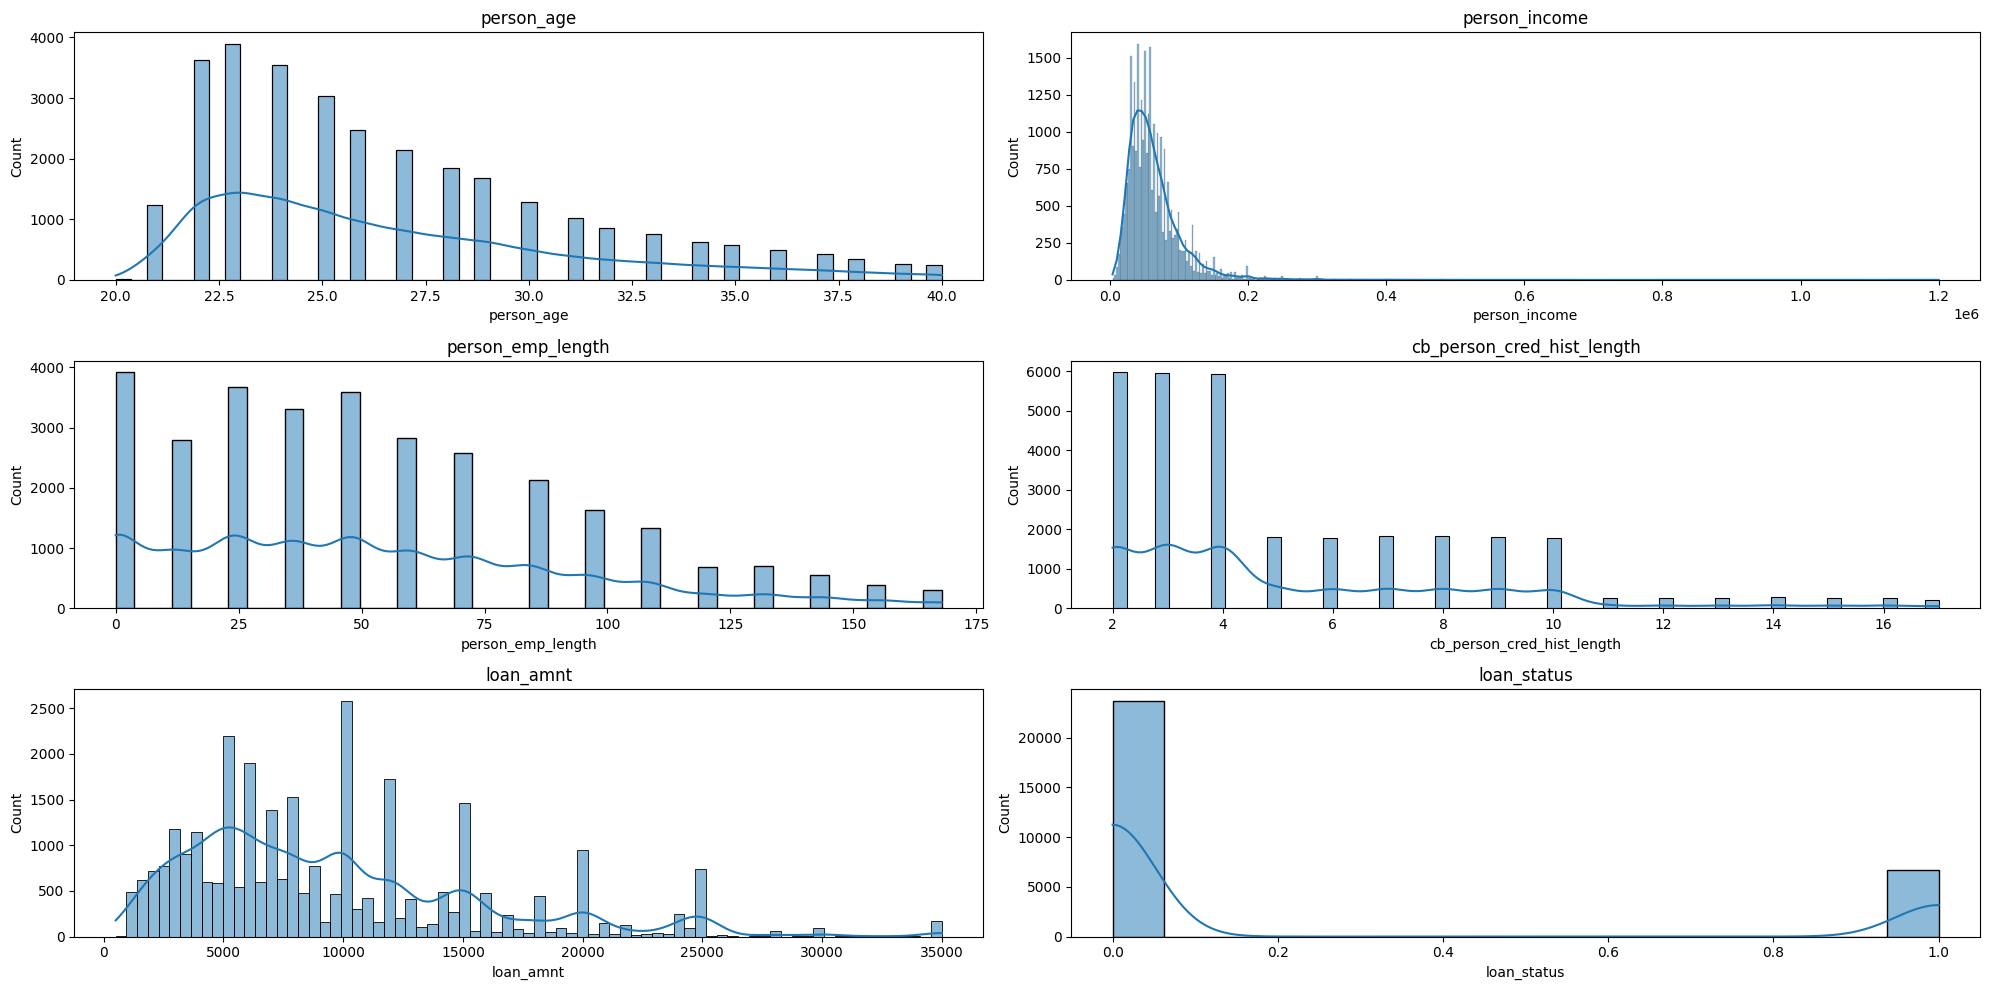

In [ ]:
# Визуализация распределения непрерывных параметров
plt.figure(figsize=(20, 10))
for i, column in enumerate(loans_ml_clear, 1):
    plt.subplot(3, 2, i)
    sns.histplot(loans_ml_clear[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

Проверим сбалансированность целевой переменной

<Axes: ylabel='loan_status'>

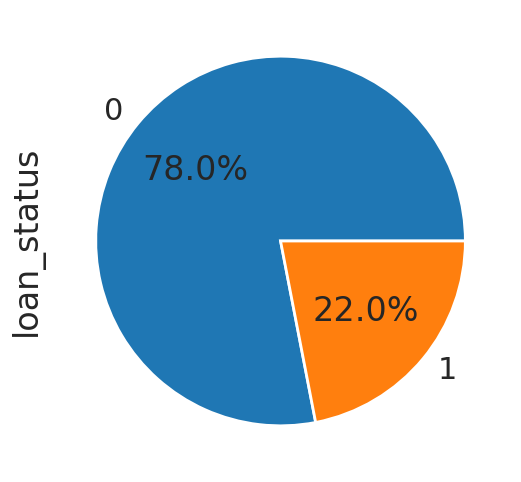

In [ ]:
# проверка, насколько целевая переменная сбалансирована
sns.set_style('darkgrid')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = [8,6]
loans_ml_clear.groupby('loan_status').size().plot(kind='pie',
                                       y = 'loan_status',
                                       label = 'loan_status',
                                       autopct='%1.1f%%')

In [ ]:
loans_ml_clear['loan_status'].value_counts()

loan_status
0    23719
1     6673
Name: count, dtype: int64

Данные несбалансированы, в дальнейшем необходимо это учесть

In [ ]:
X = loans_ml_clear.drop(['loan_status'], axis=1)
y = loans_ml_clear["loan_status"]

### Стандартизация

стандартизация - такое преобразование необходимо, поскольку признаки датасета могут иметь большие различия между своими диапазонами

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Рзделение датасета на обучающую и тестовые выборки

80% - тренировочная выборка

20% - тестовая выборка

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

In [ ]:
y_test.value_counts()

loan_status
0    4769
1    1310
Name: count, dtype: int64

Так как данные крайне несбалансированы, используем SMOTE для возможного дальнейшего применения. Это метод искусственного увеличения числа примеров редкого класса (в нашем случае 1), позволяющий улучшить качество моделей при работе с несбалансированными данными

### SMOTE

In [ ]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

## ML

### Base_model - Логистическая регрессия

In [ ]:
# model_logreg = LogisticRegression(class_weight='balanced', solver='liblinear',verbose=1)
model_logreg = LogisticRegression(class_weight='balanced')
model_logreg.fit(X_train, y_train)

y_pred_logreg = model_logreg.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred_logreg))
print("precision:", precision_score(y_test, y_pred_logreg, average = 'binary'))
print("recall:", recall_score(y_test, y_pred_logreg, average = 'binary'))
print("f1:", f1_score(y_test, y_pred_logreg, average = 'binary'))

accuracy: 0.648297417338378
precision: 0.34945454545454546
recall: 0.733587786259542
f1: 0.47339901477832513


F1-мера — это метрика, которая используется для оценки качества бинарной классификации, учитывающая как точность (precision), так и полноту (recall). Значение F1-меры варьируется от 0 до 1, где 1 означает идеальное качество классификации, а 0 — полное отсутствие качества.

Результат F1 = 0.47 сложно считать допустимым, примем его за базовый, разумеется стоит улучшать модель. При этом надо помнить, что классы сильно несбалансированы, и F1-мера может не полностью отражать качество модели.

#### Визуализация процесса обучения

In [ ]:
def plot_learning_curve(model, X, y, cv=5, scoring='accuracy', n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=n_jobs
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(20, 15))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Train Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validation Score')
    plt.title(f'Learning Curve for {model.__class__.__name__}', fontsize=16)
    plt.xlabel('Training Set Size', fontsize=14)
    plt.ylabel(scoring.capitalize(), fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.show()

    return train_sizes, train_scores_mean, test_scores_mean


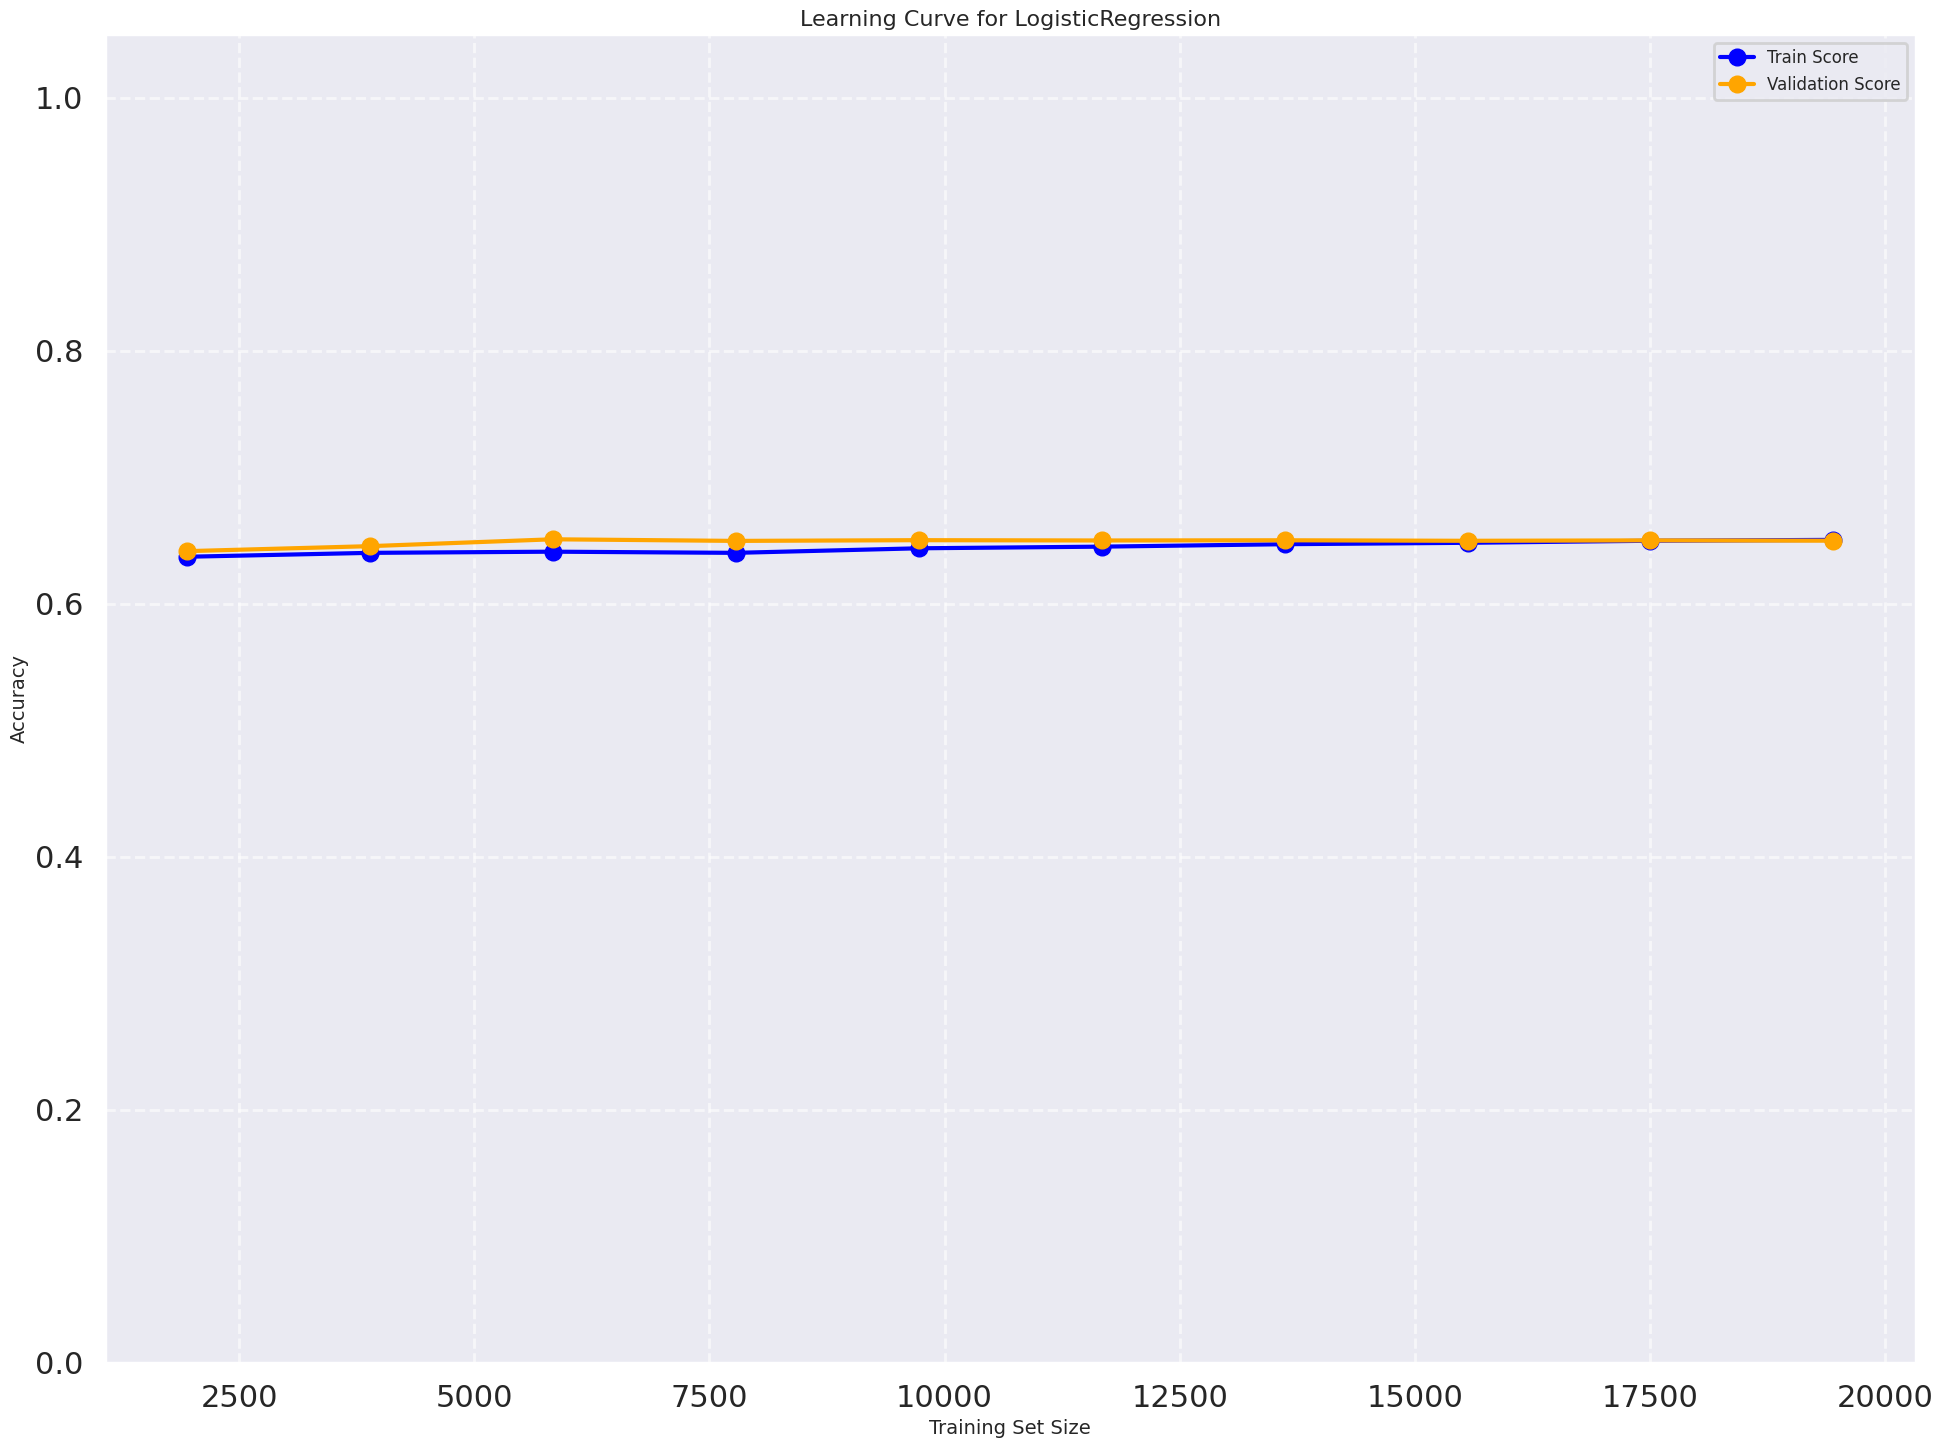

(array([ 1945,  3890,  5835,  7780,  9725, 11670, 13615, 15560, 17505,
        19450]),
 array([0.63712082, 0.64020566, 0.64113111, 0.64020566, 0.64380463,
        0.64510711, 0.64703636, 0.6481491 , 0.64976864, 0.65045758]),
 array([0.64155042, 0.64549901, 0.65092834, 0.64965311, 0.65022899,
        0.64998206, 0.65014671, 0.64973538, 0.65006442, 0.64981765]))

In [ ]:
plot_learning_curve(model_logreg, X_train, y_train, cv=5, scoring='accuracy')

#### Матрица ошибок

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    confusion_mat = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[False, True])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()


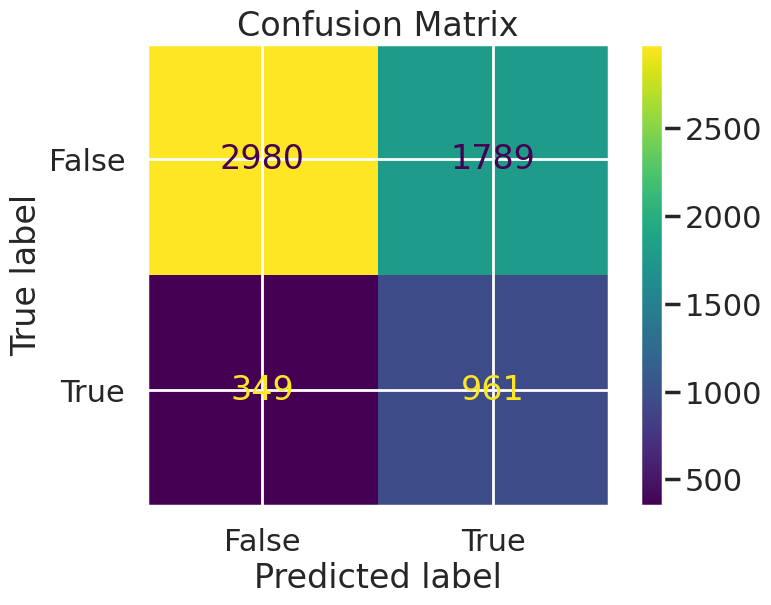

In [ ]:
plot_confusion_matrix(y_test, y_pred_logreg)

#### Вывод

Модель предсказала вероятность дефолта с точностью 47%

true loan_status - реальные значения

0 -	4769

1 -	1310

Результат:
- TP - предсказали положительную метку и угадали - 961 из 1310;
- FP - предсказали положительную метку, но ошиблись в своём предсказании - 1789;
- TN - предсказали отрицательную метку и угадали - 2980 из 4769;
- FN - предсказали отрицательную метку, но ошиблись - 349.

То есть, иными словами, модель готова "выдать" 349 потенциально невозвратных кредитов, при этом 1789 "хороших" заемщиков она забраковала.

Результат f1 = 0.47



### Выбор модели с применением инструмента GridSearch

к сравнению выбраны следующие модели:

In [ ]:
models_list=[
    LogisticRegression(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    BaggingClassifier(),
    XGBClassifier(),
]

для каждой из моделей составим списки гиперпараметров

In [ ]:
model_hyperparameters={
   'logistic' :{
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 200, 500]
   },

   'dt' : {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
   },

   'knn' : {
    'n_neighbors': [3, 5, 7, 9, 11, 13]
   },

   'rf' : {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
   },

   'gb' : {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
   },

    'bagging' : {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
   },

   'xgb' : {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
   },

}

In [ ]:
model_keys = list(model_hyperparameters.keys())
print(model_keys)

['logistic', 'dt', 'knn', 'rf', 'gb', 'bagging', 'xgb']


In [ ]:
model_hyperparameters[model_keys[0]]

{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000, 200, 500]}

функция для выбора лучшей модели

In [ ]:
def ModelSelection(list_of_models, hyperparameters_dictionary, X, y, random_state=42):
    result = []
    best_score = 0
    best_model = None
    best_model_name = ""

    for i, model in enumerate(list_of_models):
        key = model_keys[i]
        params = hyperparameters_dictionary[key]
        print(f"Training {key}...")
        classifier = GridSearchCV(model, params, cv=5, n_jobs=-1)
        classifier.fit(X, y)

        score = classifier.best_score_
        result.append({
            'model': key,
            'highest score': score,
            'best hyperparameters': classifier.best_params_
        })

        if score > best_score:
            best_score = score
            best_model = classifier.best_estimator_
            best_params = classifier.best_params_
            best_model_name = key

    print(f"\nBest model: {best_model_name}")
    print(f"Score: {best_score}")
    print(f"best_params: {best_params}")

    result_dataframe = pd.DataFrame(result, columns=['model', 'highest score', 'best hyperparameters'])
    return result_dataframe

#### Лучшая модель_вариант_1

In [ ]:
ModelSelection(models_list, model_hyperparameters, X_train, y_train)

Training logistic...
Training dt...
Training knn...
Training rf...
Training gb...
Training bagging...
Training xgb...

Best model: gb
Score: 0.8435817753631738
best_params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


model  highest score                               best hyperparameters
0  logistic       0.794431                        {'C': 10, 'max_iter': 1000}
1        dt       0.836055              {'criterion': 'gini', 'max_depth': 5}
2       knn       0.811624                                {'n_neighbors': 13}
3        rf       0.841402           {'max_depth': None, 'n_estimators': 200}
4        gb       0.843582  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...
5   bagging       0.843541  {'max_features': 1.0, 'max_samples': 0.5, 'n_e...
6       xgb       0.842019  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...

In [ ]:
best_model_gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=5,
                n_estimators=100, random_state=42)
best_model_gb.fit(X_train, y_train)
y_pred_gb = best_model_gb.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred_gb))
print("precision:", precision_score(y_test, y_pred_gb, average = 'binary'))
print("recall:", recall_score(y_test, y_pred_gb, average = 'binary'))
print("f1:", f1_score(y_test, y_pred_gb, average = 'binary'))

accuracy: 0.8471788123046554
precision: 0.7420584498094028
recall: 0.44580152671755724
f1: 0.5569861707200763


##### Визуализация процесса обучения

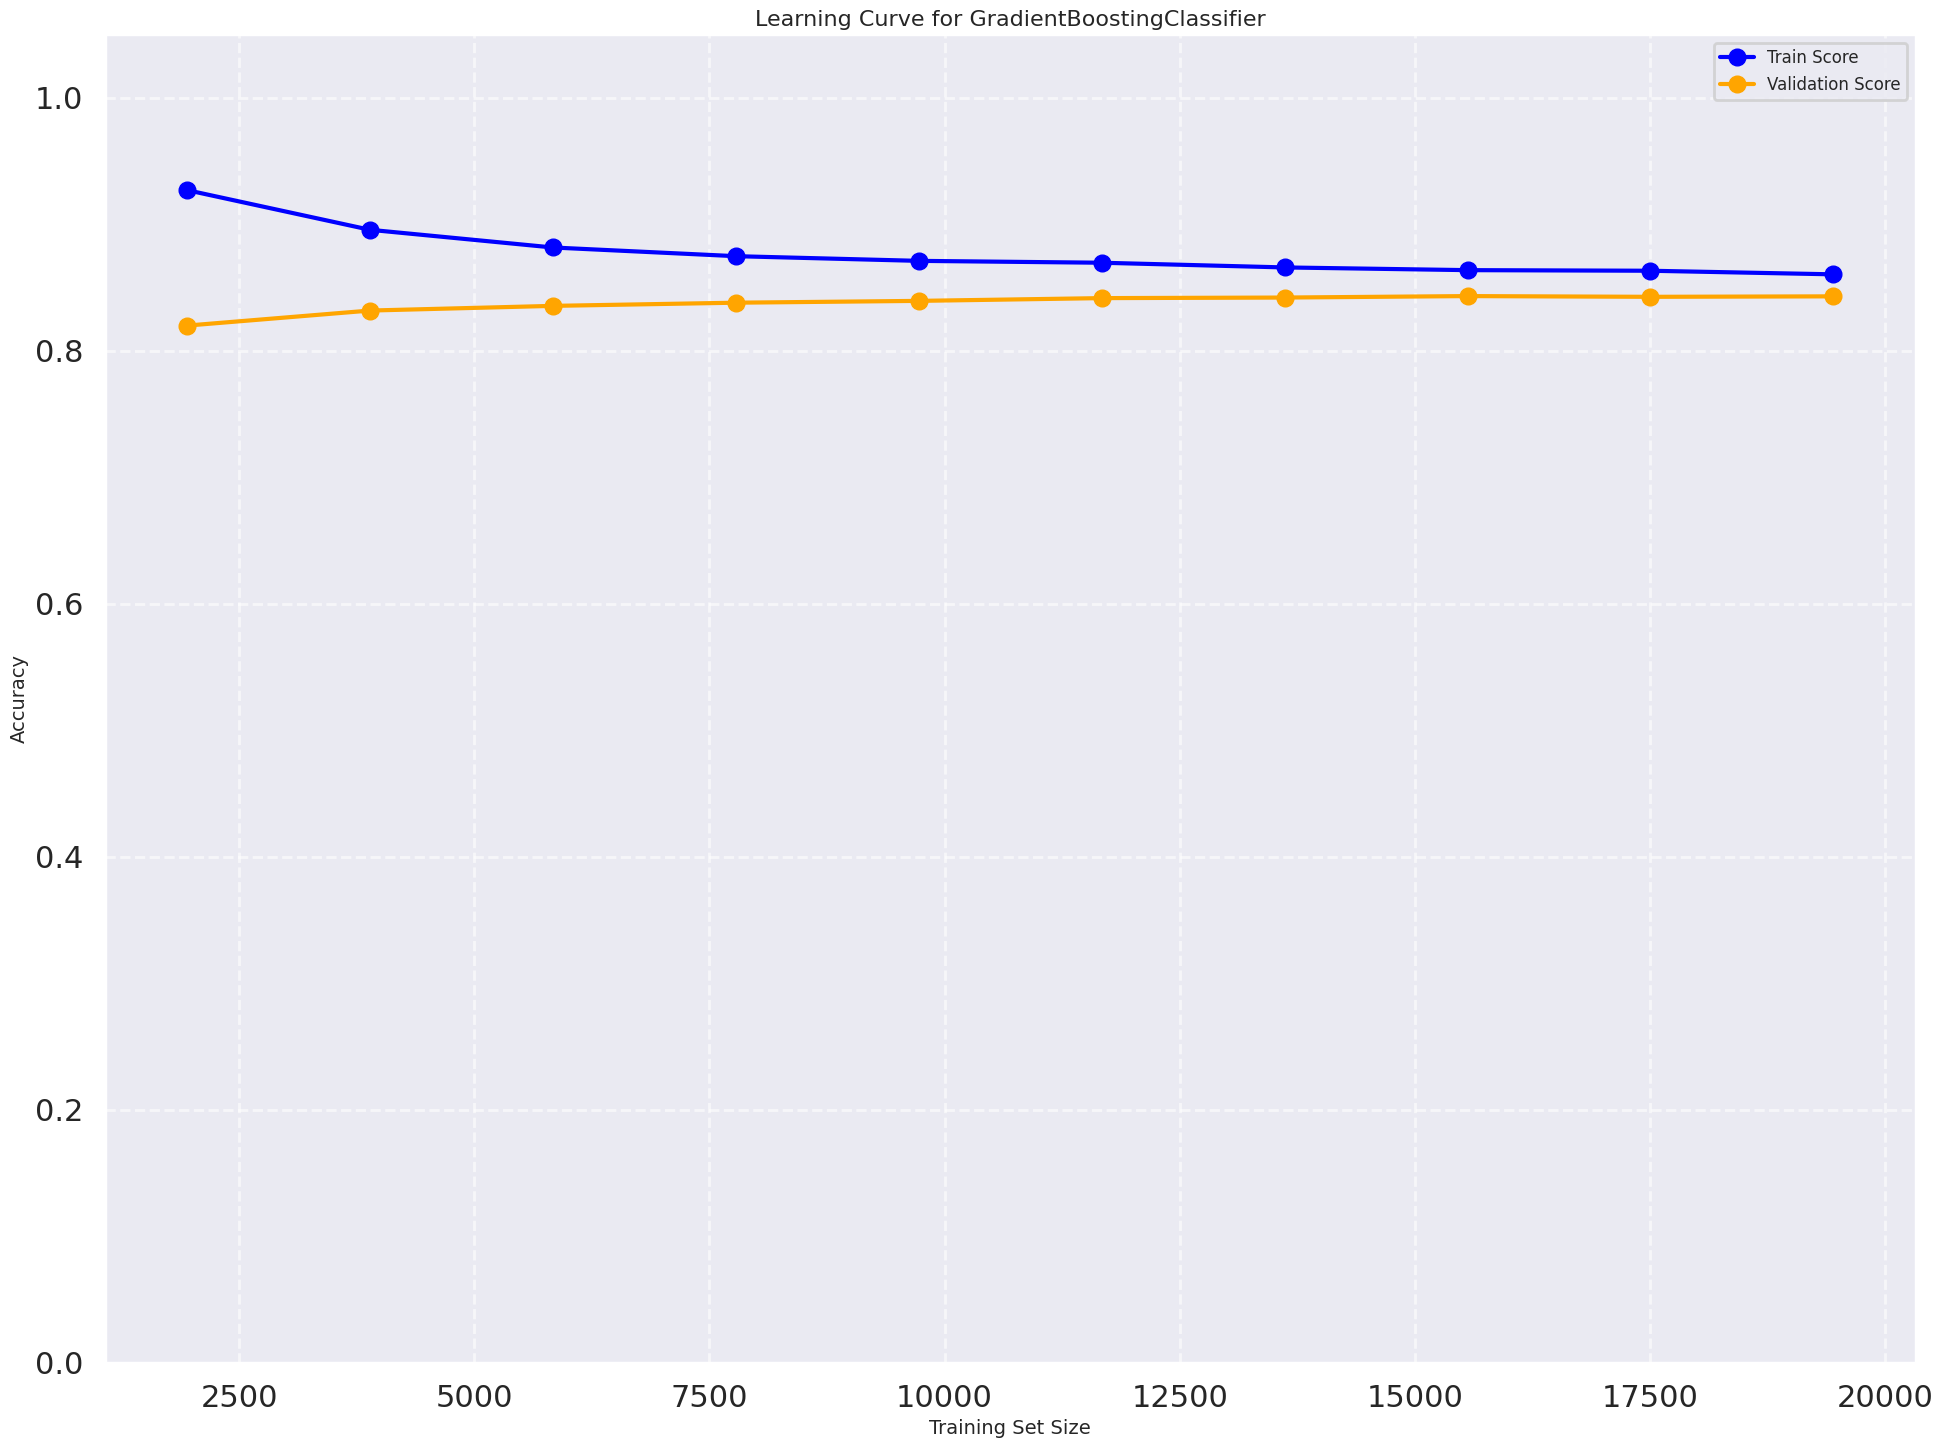

(array([ 1945,  3890,  5835,  7780,  9725, 11670, 13615, 15560, 17505,
        19450]),
 array([0.92688946, 0.89552699, 0.88154242, 0.87467866, 0.87097172,
        0.86949443, 0.86578039, 0.86363753, 0.8631591 , 0.86031877]),
 array([0.8198087 , 0.83169536, 0.83539705, 0.83790584, 0.83934537,
        0.84152522, 0.84197764, 0.84312938, 0.84255342, 0.84292369]))

In [ ]:
plot_learning_curve(best_model_gb, X_train, y_train, cv=5, scoring='accuracy')

##### Матрица ошибок

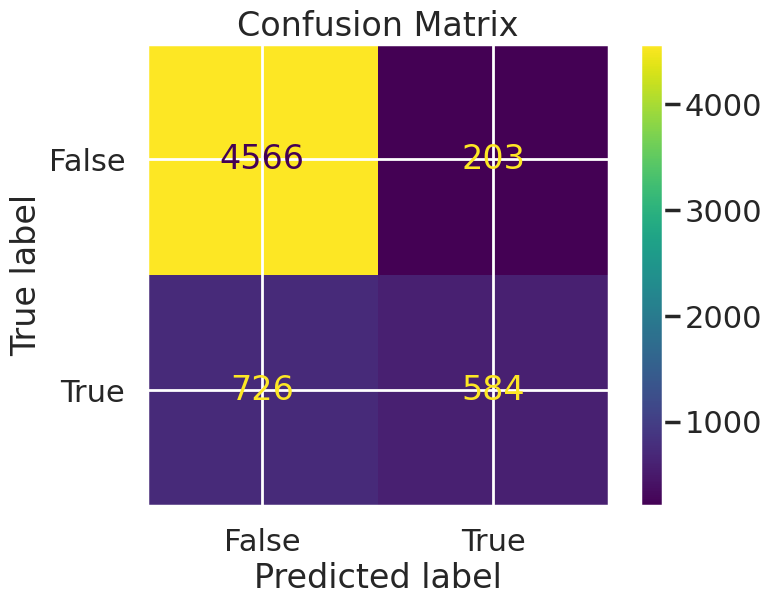

In [ ]:
plot_confusion_matrix(y_test, y_pred_gb)

##### Вывод

Несмотря на неплохие показатели на тренировочной выборке, на тестовой выборке модель показывает далеко не лучший результат.

Модель предсказала вероятность дефолта с точностью 55,7%

true loan_status - реальные значения

0 -	4769

1 -	1310

Результат:
- TP - предсказали положительную метку и угадали - 584 из 1310;
- FP - предсказали положительную метку, но ошиблись в своём предсказании - 203 - эти заемщики могли бы получить кредит, но модель им отказывает;
- TN - предсказали отрицательную метку и угадали - 4566 из 4769;
- FN - предсказали отрицательную метку, но ошиблись - 726 - это ненадежные заемщики - им нельзя выдавать кредит.

Модель готова "выдать" 726 потенциально невозвратных кредитов, но при этом всего лишь 203 положительных заемщиков она забраковала.

Результат f1 = 0.56

#### Лучшая_модель_вариант_2

Попробуем использовать увеличенный объём данных миноритарного класса (инструмент smote) без потери имеющейся информации.

In [ ]:
ModelSelection(models_list, model_hyperparameters, X_train_sm, y_train_sm)

Training logistic...
Training dt...
Training knn...
Training rf...
Training gb...
Training bagging...
Training xgb...

Best model: rf
Score: 0.8735883905013193
best_params: {'max_depth': 30, 'n_estimators': 200}


model  highest score                               best hyperparameters
0  logistic       0.683562                         {'C': 1, 'max_iter': 1000}
1        dt       0.789789          {'criterion': 'entropy', 'max_depth': 30}
2       knn       0.817203                                 {'n_neighbors': 3}
3        rf       0.873588             {'max_depth': 30, 'n_estimators': 200}
4        gb       0.865778  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...
5   bagging       0.857546  {'max_features': 0.7, 'max_samples': 0.7, 'n_e...
6       xgb       0.853931  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...

In [ ]:
best_model_rf = RandomForestClassifier(max_depth=30,
                n_estimators=200, random_state=42)
best_model_rf.fit(X_train_sm, y_train_sm)
y_pred_rf = best_model_rf.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred_rf))
print("precision:", precision_score(y_test, y_pred_rf, average = 'binary'))
print("recall:", recall_score(y_test, y_pred_rf, average = 'binary'))
print("f1:", f1_score(y_test, y_pred_rf, average = 'binary'))

accuracy: 0.824148708669189
precision: 0.600166251039069
recall: 0.5511450381679389
f1: 0.5746120175089534


##### Визуализация процесса оббучения

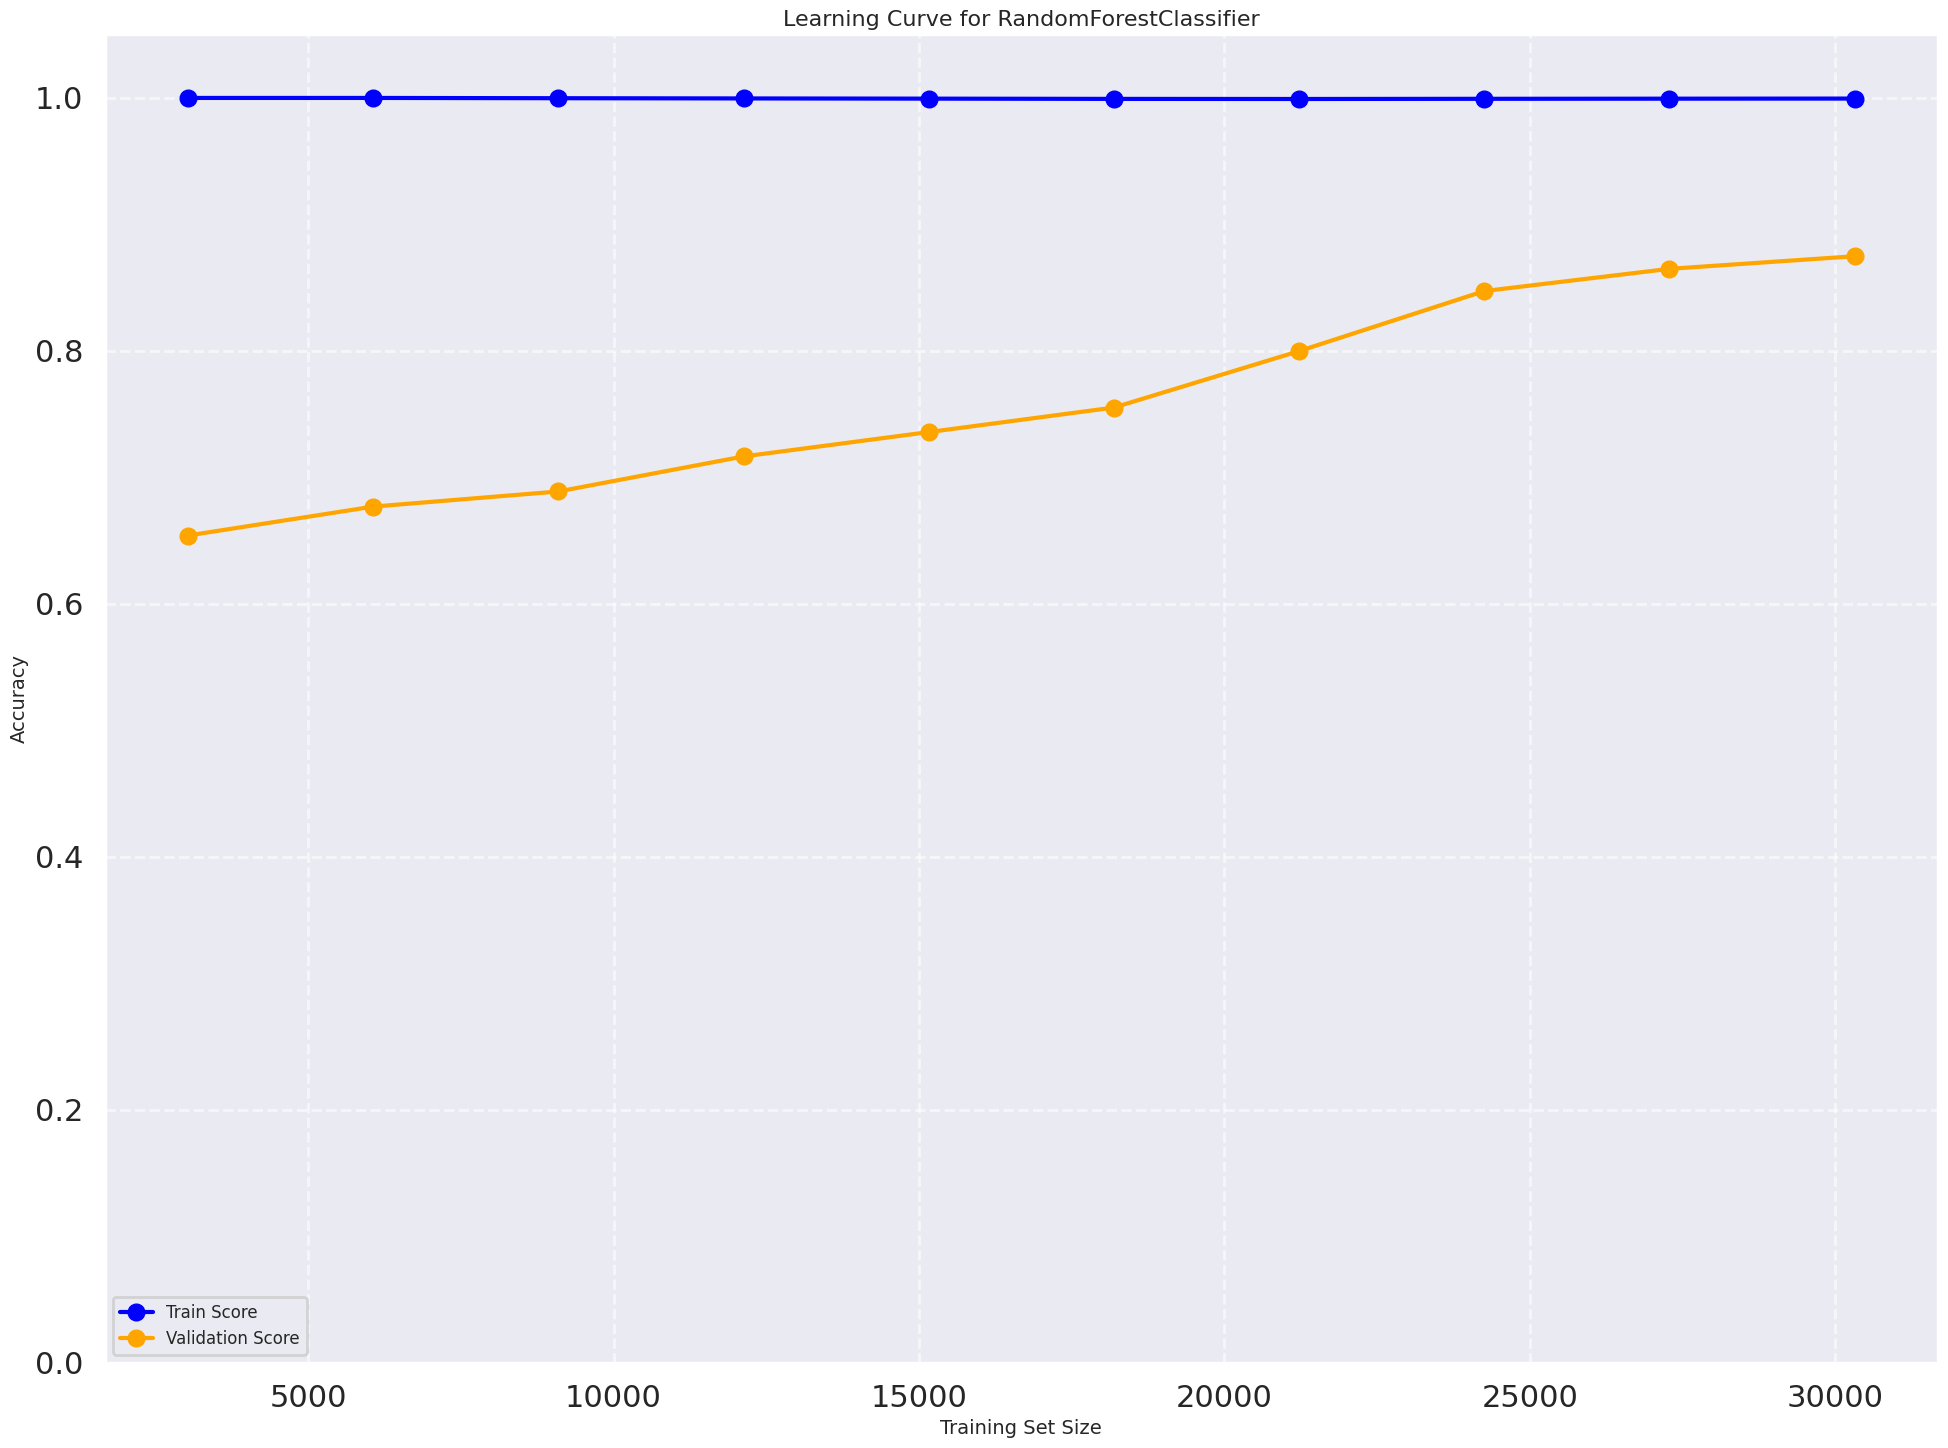

(array([ 3032,  6064,  9096, 12128, 15160, 18192, 21224, 24256, 27288,
        30320]),
 array([0.99973615, 0.99973615, 0.99951627, 0.99934037, 0.99918206,
        0.99897757, 0.9989069 , 0.99904354, 0.99914981, 0.99923483]),
 array([0.65390501, 0.67675462, 0.68870712, 0.71638522, 0.73564644,
        0.75503958, 0.79965699, 0.84709763, 0.86467018, 0.87461741]))

In [ ]:
plot_learning_curve(best_model_rf, X_train_sm, y_train_sm, cv=5, scoring='accuracy')

##### Матрица ошибок

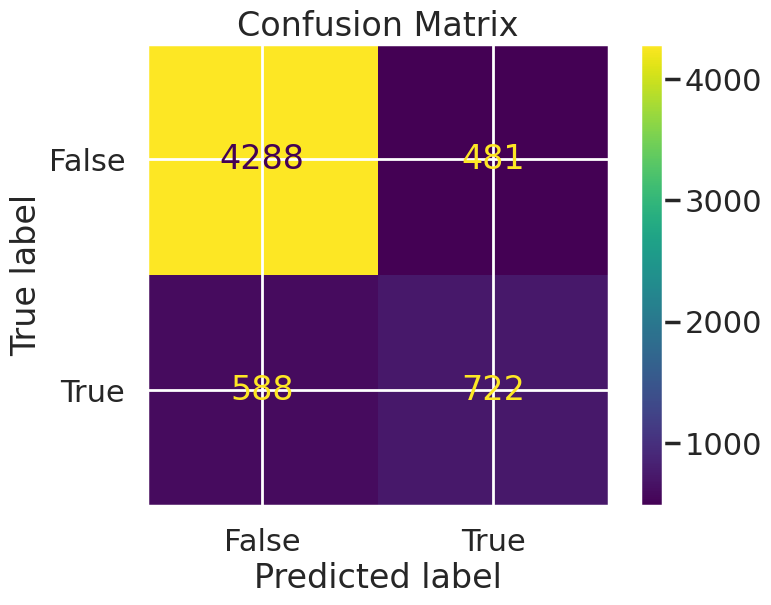

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf)

##### Вывод

Показатели не ухудшились, но и прорывного эффекта не случилось

Модель предсказала вероятность дефолта с точностью 57%

true loan_status - реальные значения

0 -	4769

1 -	1310

Результат:
- TP - предсказали положительную метку и угадали - 722 из 1310;
- FP - предсказали положительную метку, но ошиблись в своём предсказании - 481 - эти заемщики могли бы получить кредит;
- TN - предсказали отрицательную метку и угадали - 4288 из 4769;
- FN - предсказали отрицательную метку, но ошиблись - 588 - ненадежные заемщики, но модель готова им одобрить кредитную заявку.

Модель готова "выдать" 588 потенциально невозвратных кредитов, но при этом всего лишь 481 "хороших" заемщиков она забраковала.

Результат f1 = 0.57

## NN

### Установка необходимых библиотек

In [ ]:
!pip install keras >> --quiet

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

### Создание модели

In [ ]:
def create_nn_model(input_dim):
    model = Sequential([
        keras.layers.Dense(8, input_dim=input_dim, activation='relu',
                          kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        keras.layers.Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        keras.layers.Dense(64, activation='relu'),
        Dropout(0.4),

        keras.layers.Dense(32, activation='relu'),
        Dropout(0.3),

        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )

    return model

In [ ]:
# создание модели
nn_model = create_nn_model(X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True) # ранняя остановка для
                                                                                          # решения проблемы переобучения

In [ ]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,113 (78.57 KB)

 Trainable params: 19,713 (77.00 KB)

 Non-trainable params: 400 (1.56 KB)

### Обучение модели

In [ ]:
history = nn_model.fit(X_train, y_train, epochs=30, batch_size=32,
                       validation_split=0.2,
                       callbacks=[early_stopping],
                       verbose=1)

Epoch 1/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.7271 - auc: 0.5549 - loss: 0.6589 - precision: 0.2826 - recall: 0.1478 - val_accuracy: 0.7744 - val_auc: 0.7362 - val_loss: 0.5227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7721 - auc: 0.6390 - loss: 0.5454 - precision: 0.4354 - recall: 0.0494 - val_accuracy: 0.7779 - val_auc: 0.7583 - val_loss: 0.4955 - val_precision: 0.6604 - val_recall: 0.0319
Epoch 3/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7841 - auc: 0.6830 - loss: 0.5176 - precision: 0.5714 - recall: 0.1060 - val_accuracy: 0.7868 - val_auc: 0.7638 - val_loss: 0.4806 - val_precision: 0.7113 - val_recall: 0.0921
Epoch 4/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7956 - auc: 0.7072 - loss: 0.4934 - precision: 0.5883 - recall: 0.1617 - val_accuracy: 0.7806 - val_auc: 0.7668 - val_loss: 0.4900 - val_precision: 0.6596 - val_recall: 0.0565
Epoch 5/30
608/608 ━━━

#### Визуализация процесса обучения

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

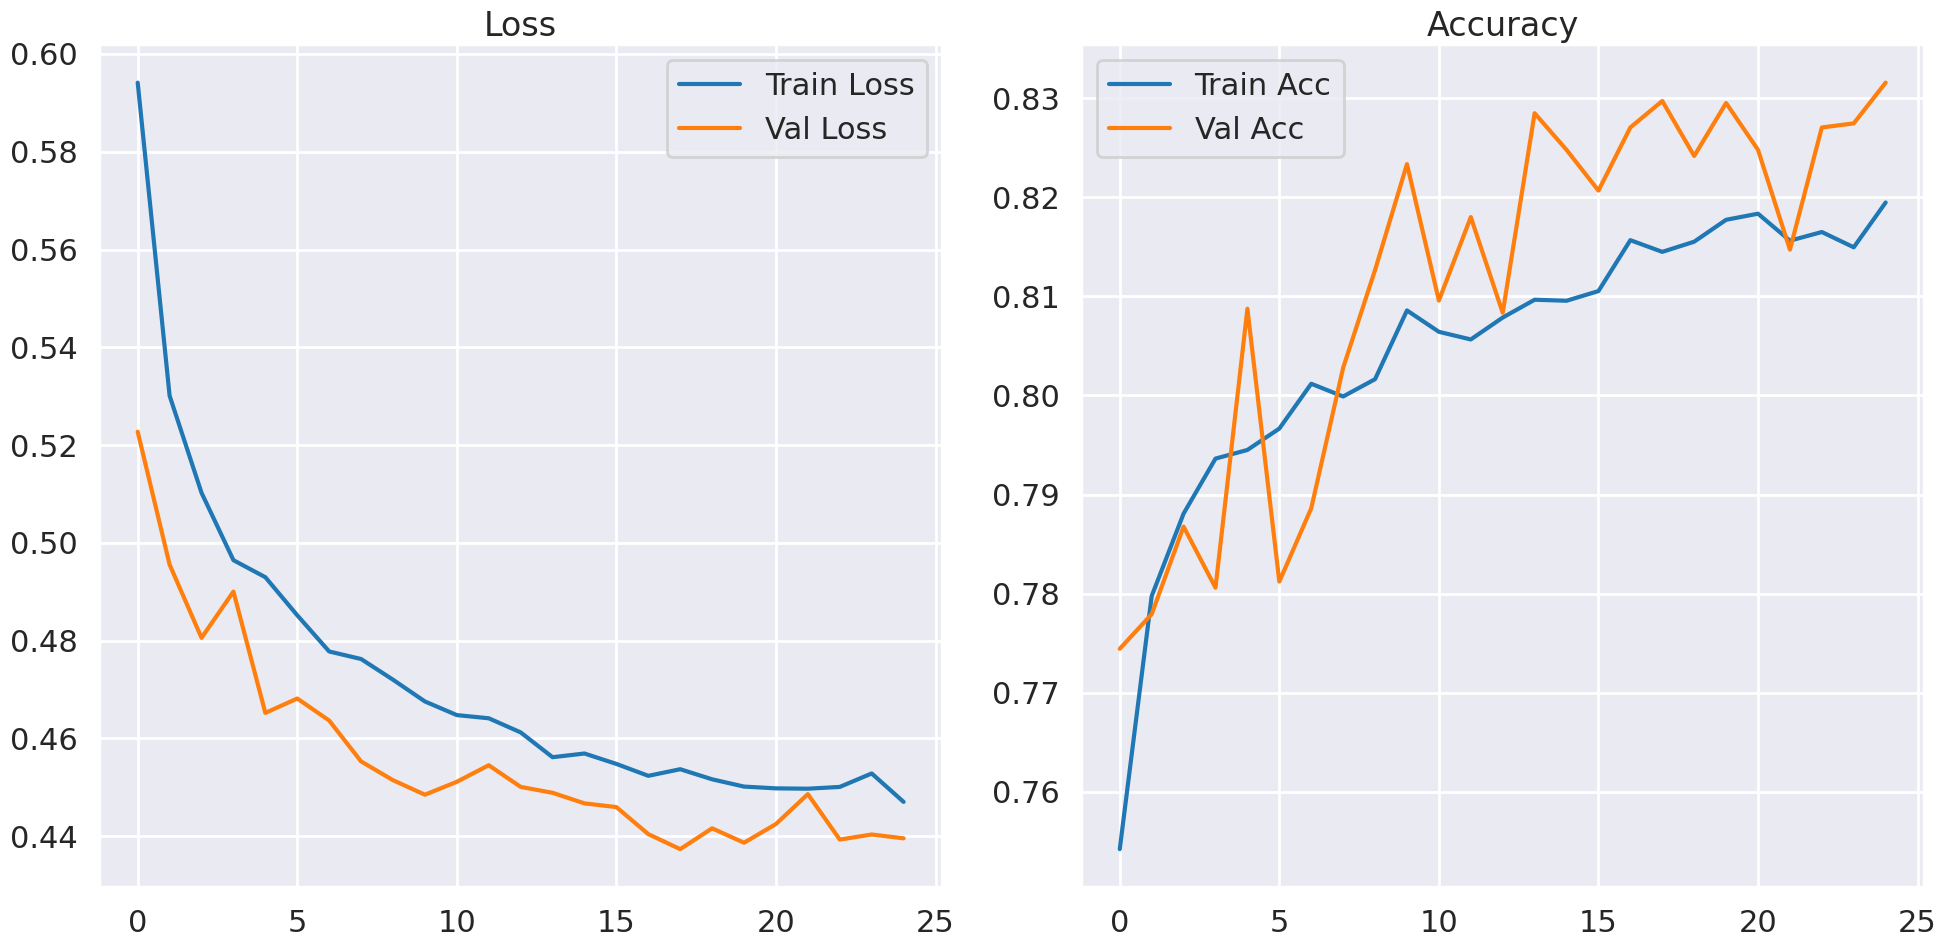

In [ ]:
plot_accuracy(history)

In [ ]:
y_pred_nn = nn_model.predict(X_test)

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
y_pred_nn[:11]

array([[0.08421522],
       [0.20634505],
       [0.17848507],
       [0.08403024],
       [0.09111659],
       [0.2223025 ],
       [0.08925667],
       [0.1348779 ],
       [0.27533188],
       [0.1238903 ],
       [0.09098338]], dtype=float32)

In [ ]:
# округление до целых
y_pred_binary = (y_pred_nn >= 0.5).astype(int)

In [ ]:
print("accuracy:", accuracy_score(y_test, y_pred_binary))
print("precision:", precision_score(y_test, y_pred_binary, average = 'binary'))
print("recall:", recall_score(y_test, y_pred_binary, average = 'binary'))
print("f1:", f1_score(y_test, y_pred_binary, average = 'binary'))

accuracy: 0.8297417338378023
precision: 0.6870748299319728
recall: 0.38549618320610685
f1: 0.4938875305623472


#### Матрица ошибок

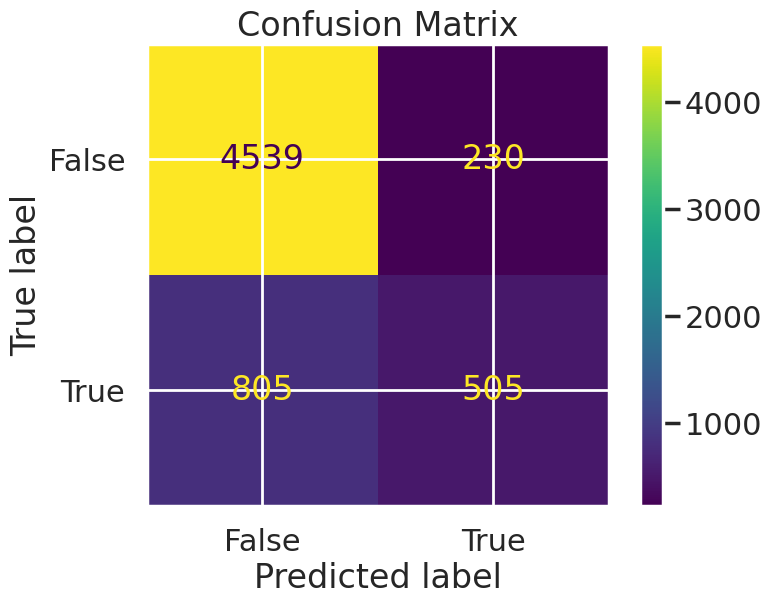

In [ ]:
plot_confusion_matrix(y_test, y_pred_binary)

#### Вывод

Модель предсказала вероятность дефолта с точностью 49.4%

true loan_status - реальные значения

0 -	4769

1 -	1310

Результат:
- TP - предсказали положительную метку и угадали - 505 из 1310;
- FP - предсказали положительную метку, но ошиблись в своём предсказании - 230 - положительные заемщики, но модлеь их отклонила;
- TN - предсказали отрицательную метку и угадали - 4539 из 4769;
- FN - предсказали отрицательную метку, но ошиблись - 805 - ненадежные заемщики, которым модель одобрила заявку.

Модель готова "выдать" 805 потенциально невозвратных кредитов, но при этом всего лишь 230 "хороших" заемщиков она забраковала.

Результат f1 = 0.49

### Обучение модели на smote-данных

In [ ]:
history_sm = nn_model.fit(X_train_sm, y_train_sm, epochs=30, batch_size=32,
                       validation_split=0.2,
                       callbacks=[early_stopping],
                       verbose=1)

Epoch 1/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7388 - auc: 0.7533 - loss: 0.5648 - precision: 0.7658 - recall: 0.4383 - val_accuracy: 0.4466 - val_auc: 0.0000e+00 - val_loss: 0.8515 - val_precision: 1.0000 - val_recall: 0.4466
Epoch 2/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7383 - auc: 0.7537 - loss: 0.5613 - precision: 0.7542 - recall: 0.4534 - val_accuracy: 0.4303 - val_auc: 0.0000e+00 - val_loss: 0.8242 - val_precision: 1.0000 - val_recall: 0.4303
Epoch 3/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7421 - auc: 0.7518 - loss: 0.5592 - precision: 0.7621 - recall: 0.4409 - val_accuracy: 0.4708 - val_auc: 0.0000e+00 - val_loss: 0.8182 - val_precision: 1.0000 - val_recall: 0.4708
Epoch 4/30
948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7395 - auc: 0.7547 - loss: 0.5603 - precision: 0.7659 - recall: 0.4471 - val_accuracy: 0.4553 - val_auc: 0.0000e+00 - val_loss: 0.7921 - val_precision: 1.0000 - val_recall: 0.4553
Epoch 5/30
94

#### Визуализация процесса обучения

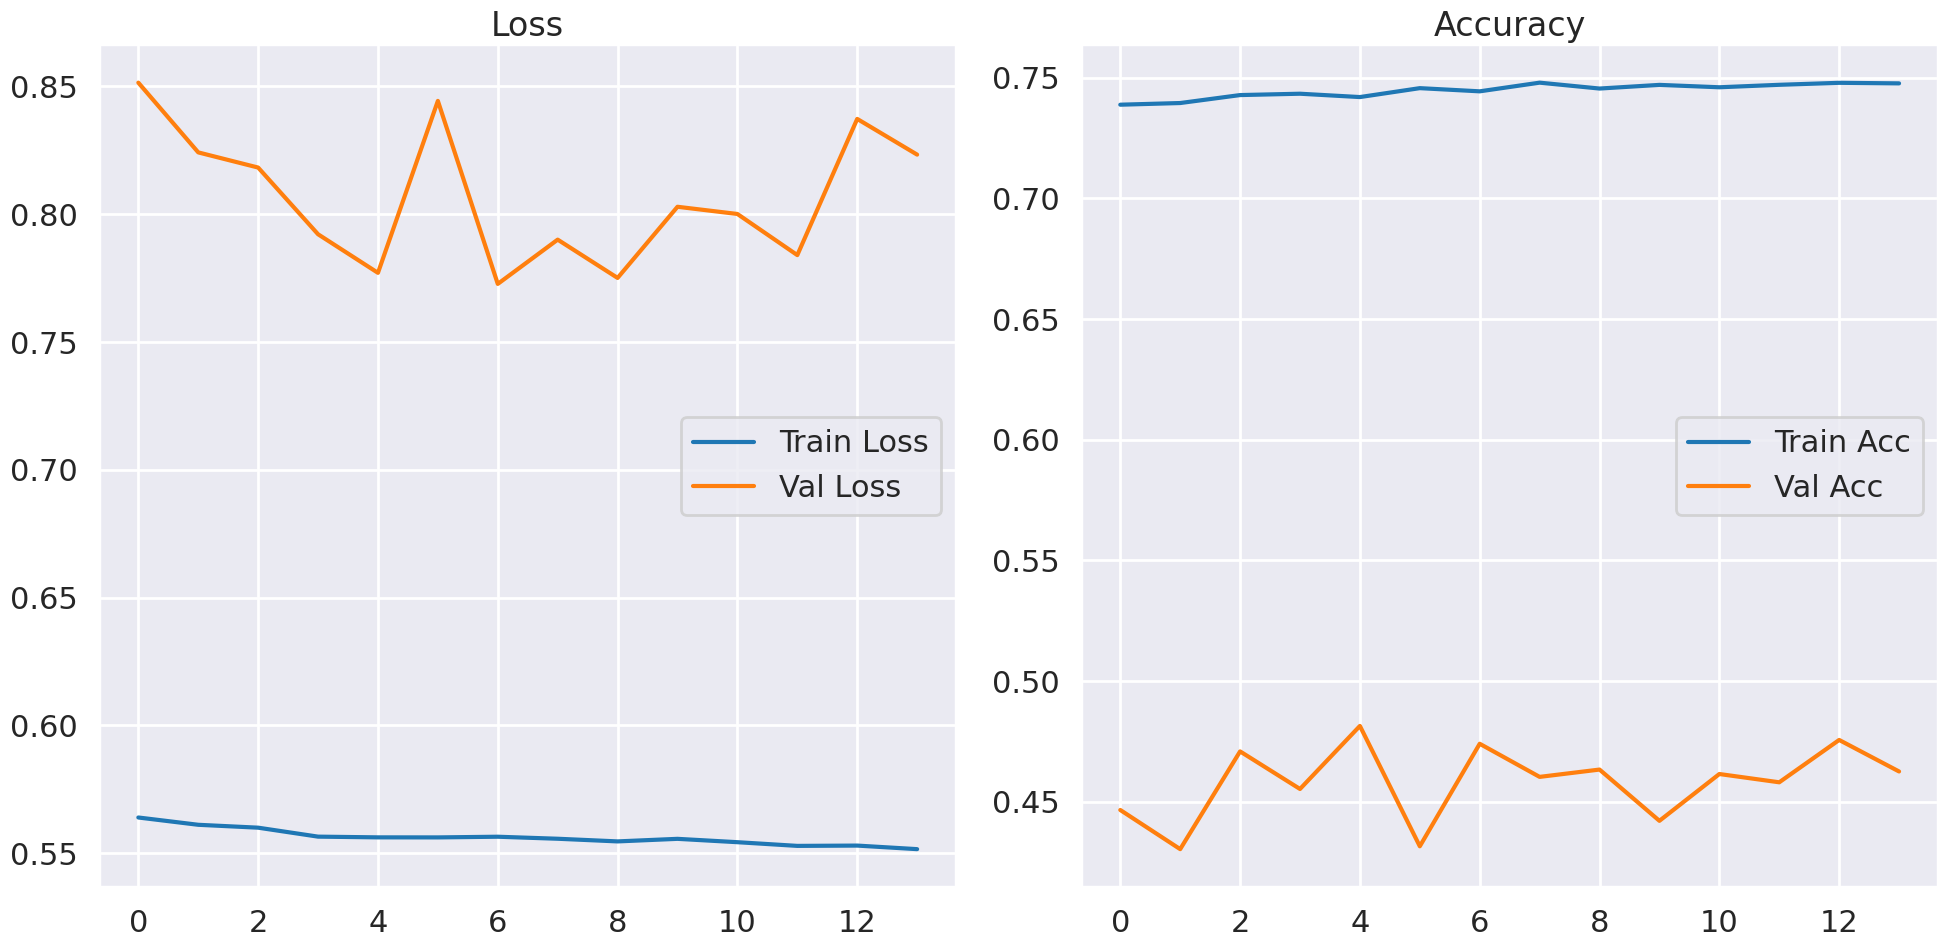

In [ ]:
plot_accuracy(history_sm)

In [ ]:
y_pred_nn_sm = nn_model.predict(X_test)

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
y_pred_binary_sm = (y_pred_nn_sm >= 0.5).astype(int)

In [ ]:
print("accuracy:", accuracy_score(y_test, y_pred_binary_sm))
print("precision:", precision_score(y_test, y_pred_binary_sm, average = 'binary'))
print("recall:", recall_score(y_test, y_pred_binary_sm, average = 'binary'))
print("f1:", f1_score(y_test, y_pred_binary_sm, average = 'binary'))

accuracy: 0.8225037012666557
precision: 0.6196891191709845
recall: 0.45648854961832064
f1: 0.5257142857142857


#### Матрица ошибок

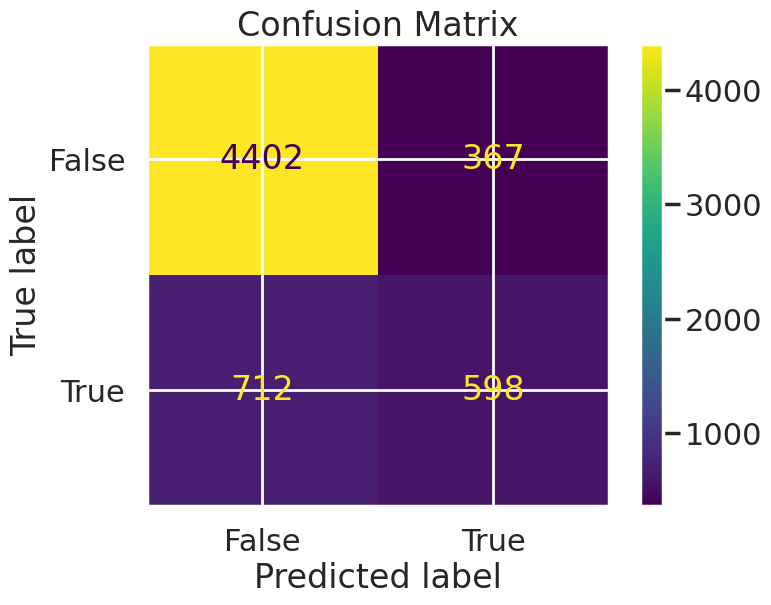

In [ ]:
plot_confusion_matrix(y_test, y_pred_binary_sm)

#### Вывод

Модель предсказала вероятность дефолта с точностью 52.6%

true loan_status - реальные значения

0 -	4769

1 -	1310

Результат:
- TP - предсказали положительную метку и угадали - 598 из 1310;
- FP - предсказали положительную метку, но ошиблись в своём предсказании - 367 - могли бы получить кредит (надежные заемщики);
- TN - предсказали отрицательную метку и угадали - 4402 из 4769;
- FN - предсказали отрицательную метку, но ошиблись - 712 - ненадежные заемщики, но модель готова одобрить заявку.

Модель готова "выдать" 712 потенциально невозвратных кредитов, но при этом 367 "хороших" заемщиков она забраковала.

Результат f1 = 0.53

## Вывод

Наиболее высокие метрики f1 показали модели RandomForestClassifier (f1 = 0.57) и GradientBoostingClassifier(f1 = 0.56). Предлагаю лучшей считать модель RFC, так как она меньше "ошибается" в предсказании "хороших кредитов", которые на самом деле нельзя выдавать, а в кредитном бизнесе, на мой взгляд, - это критически важно.
Поэтому после анализа результатов выбираем модель RandomForestClassifier и сохраняем ее.

## Сохранение лучшей модели

In [ ]:
with open(f'best_model.pkl', 'wb') as f:
        pickle.dump(best_model_rf, f)

# Разработка Telegram-бота

Разработка Telegram-бота для прогнозирования вероятности одобрения кредита, который обеспечивает удобное взаимодействие с пользователем и использует современные методы машинного обучения для наиболее точного анализа данных и оценки кредитоспособности заемщика.

## Загрузка необходимых библиотек

In [ ]:
!pip install python-telegram-bot --quiet
!pip install nest_asyncio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.7/708.7 kB 15.7 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()

from pathlib import Path
from telegram import Update
from telegram.ext import (
    ApplicationBuilder,
    CommandHandler,
    MessageHandler,
    filters,
    ConversationHandler,
    ContextTypes,
)

## Загрузка модели

In [ ]:
project_root = Path('.')
model_path = project_root / 'best_model.pkl'

with open(model_path, 'rb') as f:
    model = pickle.load(f)

In [ ]:
AGE, INCOME, EMP_LENGTH, HIST_LENGTH, LOAN_AMOUNT = range(5)

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):

    await update.message.reply_text(
        "Здравствуйте! Я бот для оценки вероятности получения кредита.\n"
        "Сколько Вам лет?")
    return AGE

async def age(update: Update, context: ContextTypes.DEFAULT_TYPE):
    try:
        context.user_data['age'] = int(update.message.text)
    except ValueError:
        await update.message.reply_text("Пожалуйста, введите корректный возраст (число).")
        return AGE

    await update.message.reply_text("Введите Ваш годовой доход:")
    return INCOME

async def income(update: Update, context: ContextTypes.DEFAULT_TYPE):
    try:
        context.user_data['income'] = int(update.message.text)
    except ValueError:
        await update.message.reply_text("Пожалуйста, введите корректный доход (число).")
        return INCOME

    await update.message.reply_text("Введите Ваш стаж работы (в месяцах):")
    return EMP_LENGTH

async def emp_length(update: Update, context: ContextTypes.DEFAULT_TYPE):
    try:
        context.user_data['emp_length'] = int(update.message.text)
    except ValueError:
        await update.message.reply_text("Пожалуйста, введите корректные данные (число).")
        return EMP_LENGTH

    await update.message.reply_text("Введите длительность кредитной истории (в месяцах):")
    return HIST_LENGTH

async def hist_length(update: Update, context: ContextTypes.DEFAULT_TYPE):
    try:
        context.user_data['hist_length'] = int(update.message.text)
    except ValueError:
        await update.message.reply_text("Пожалуйста, введите корректные данные (число).")
        return HIST_LENGTH

    await update.message.reply_text("Введите запрашиваемую сумму кредита:")
    return LOAN_AMOUNT

async def loan_amount(update: Update, context: ContextTypes.DEFAULT_TYPE):
    try:
        context.user_data['loan_amount'] = float(update.message.text)
    except ValueError:
        await update.message.reply_text("Пожалуйста, введите корректную сумму кредита (число).")
        return LOAN_AMOUNT

    input_data = np.array([[
        context.user_data['age'],
        context.user_data['income'],
        context.user_data['emp_length'],
        context.user_data['hist_length'],
        context.user_data['loan_amount']
    ]])

    prediction = model.predict(input_data)

    if prediction[0] == 0:
        answer = "✅ Поздравляю, Ваш кредит одобрен."
    else:
        answer = "❌ К сожалению, Ваша заявка отклонена."

    await update.message.reply_text(answer)
    return ConversationHandler.END

async def cancel(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text("Операция отменена.")
    return ConversationHandler.END

async def stop(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text("Бот останавливается...")
    await context.application.stop()

def main():
    TOKEN = "8191207779:AAF8KwT6PUvBVDRdoJRr8rPQQH2o8dzndPo"

    application = ApplicationBuilder().token(TOKEN).build()

    conv_handler = ConversationHandler(
        entry_points=[CommandHandler('start', start)],
        states={
            AGE: [MessageHandler(filters.TEXT & ~filters.COMMAND, age)],
            INCOME: [MessageHandler(filters.TEXT & ~filters.COMMAND, income)],
            EMP_LENGTH: [MessageHandler(filters.TEXT & ~filters.COMMAND, emp_length)],
            HIST_LENGTH: [MessageHandler(filters.TEXT & ~filters.COMMAND, hist_length)],
            LOAN_AMOUNT: [MessageHandler(filters.TEXT & ~filters.COMMAND, loan_amount)],
        },
        fallbacks=[CommandHandler('cancel', cancel)],
    )

    application.add_handler(conv_handler)
    application.add_handler(CommandHandler('stop', stop))

    print("Бот запущен...")
    application.run_polling()

if __name__ == '__main__':
    main()


## Положительный результат


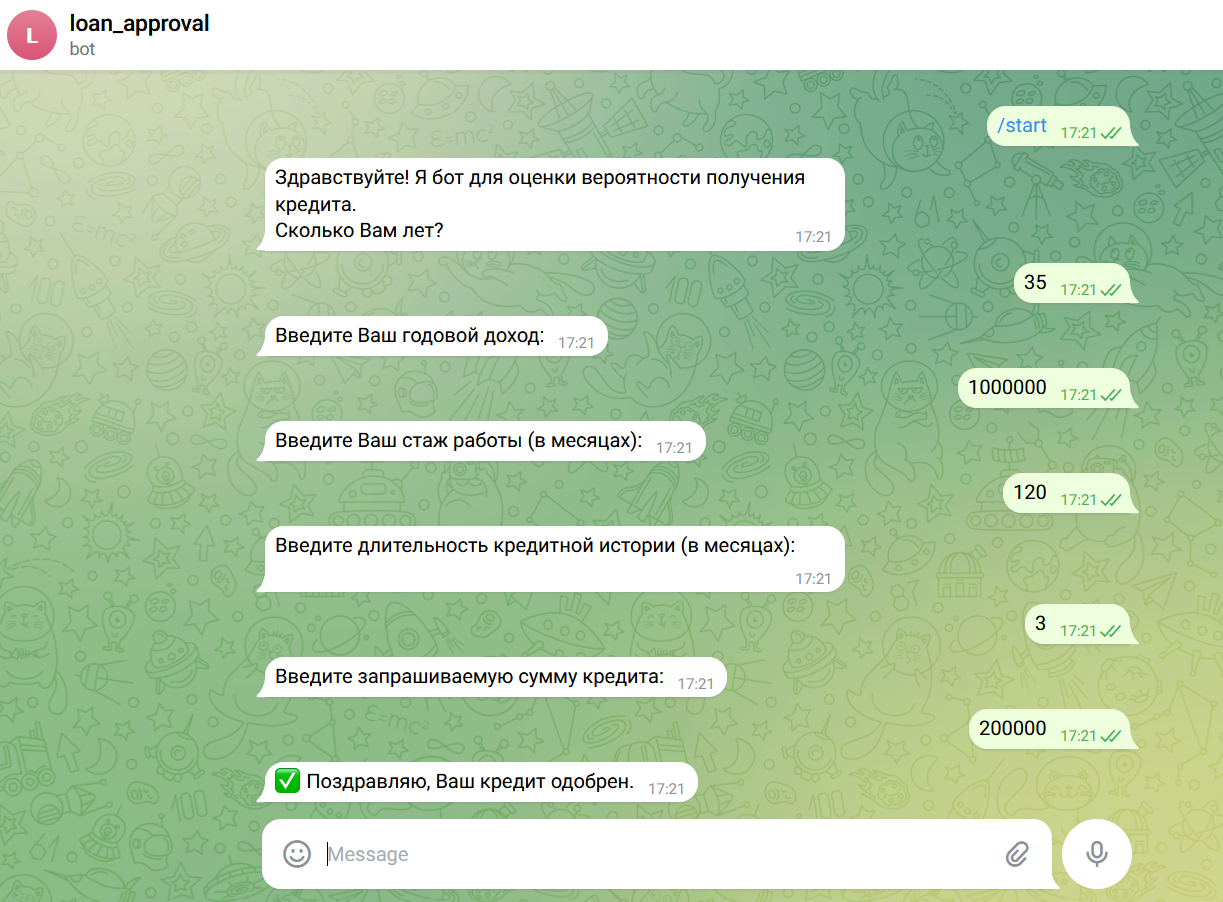

## Отрицательный результат

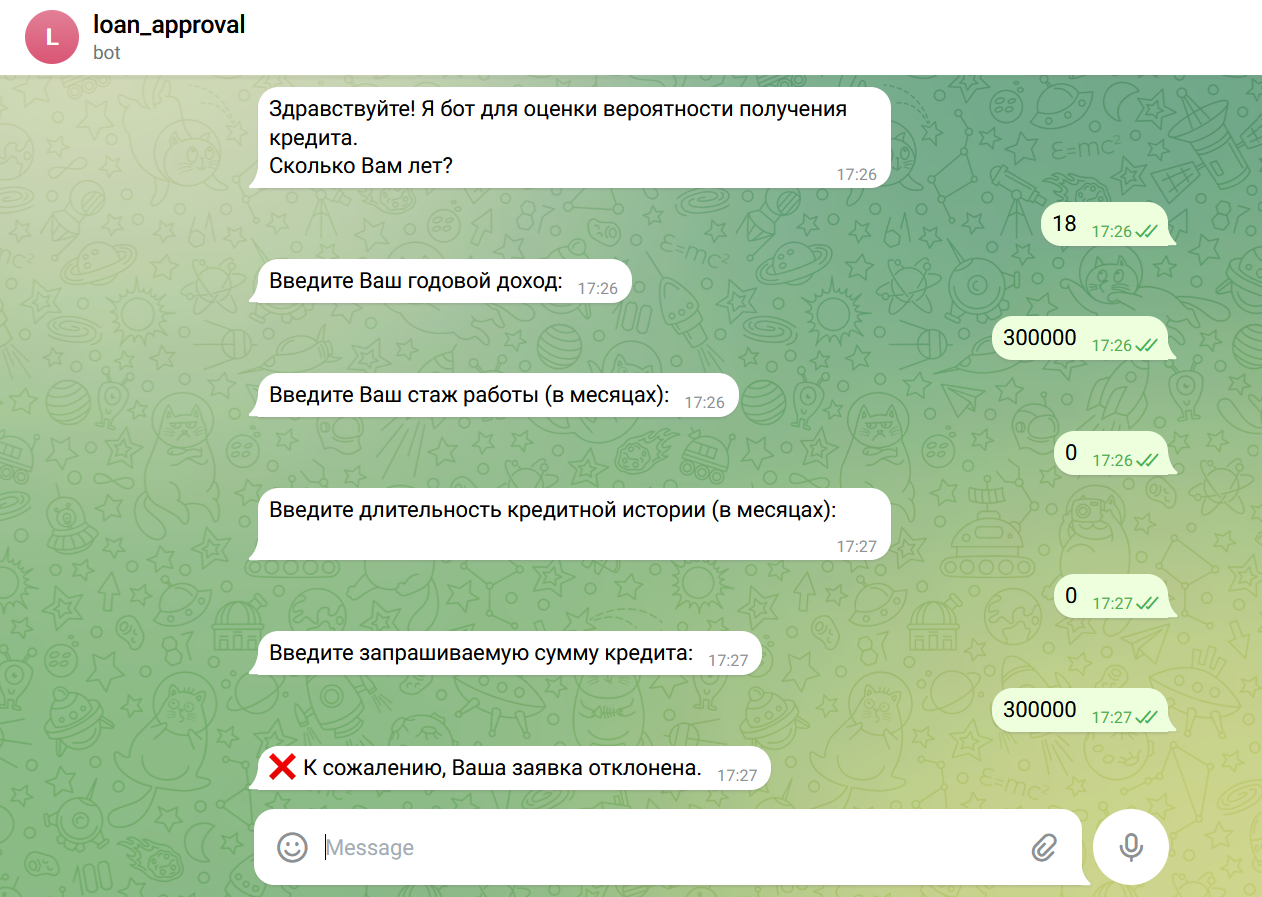

# Вывод

В данной работе был проведён комплексный анализ и практическая реализация методов оценки и управления кредитным портфелем с использованием современных технологий и инструментов обработки данных. В ходе исследования были рассмотрены ключевые этапы и вопросы, касающиеся подготовки данных, визуализации, анализа и применения машинного обучения в кредитном скоринге, а также разработка удобного Telegram-бота, объединяющего все перечисленные знания и методы для интерактивного взаимодействия с пользователями.